<img src="./logo_UTN.svg" align="right" width="150" /> 


<br><br>
#### Procesamiento Digital de Señales

# Trabajo Práctico Nº5
#### Alumno:    Fernando Daniel Fiamberti


##  Filtrado digital lineal de ECG (1ra parte)

# <span style="color:Blue">Enunciado</span>


### Usando el archivo ecg.mat que contiene un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:

    Ruido causado por el movimiento de los electrodos (Alta frecuencia).
    Ruido muscular (Alta frecuencia).
    Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia).

Ayuda: Los detalles de cómo acceder a ecg.mat los pueden encontrar en lectura_sigs.py
Archivo ECG.mat

(variables)

    ecg_lead: Registro de ECG muestreado a f s igual 1  KHz durante una prueba de esfuerzo
    qrs_pattern1: Complejo de ondas QRS normal
    heartbeat_pattern1: Latido normal
    heartbeat_pattern2: Latido de origen ventricular
    qrs_detections: vector con las localizaciones (en # de muestras) donde ocurren los latidos


Se pide:


a) Establezca una plantilla de diseño para los filtros digitales que necesitará para que la señal de ECG se asemeje a los latidos promedio en cuanto a  suavidad de los trazos y nivel isoeléctrico nulo.
Ayuda:  Utilice los resultados del ancho de banda estimado del ECG en la Tarea Semanal anterior. Tome como referencia las siguientes morfologías promedio para evaluar cualitativamente la efectividad de los filtros diseñados.

Plantilla




SinusRhythmLabels.svg
By Created by Agateller (Anthony Atkielski), converted to svg by atom. - SinusRhythmLabels.png, Public Domain, Link
 

b) ¿Cómo obtuvo dichos valores? Describa el procedimiento para establecer los valores de la plantilla.

c) Diseñe al menos dos filtros FIR y dos IIR para su comparación. Verifique que la respuesta en frecuencia responda a la plantilla de diseño.

Ayuda: Para los filtros IIR adopte las aproximaciones de módulo de máxima planicidad, Chebyshev y Cauer. Para los FIR, utilice las metodologías de ventanas, cuadrados mínimos y Parks-Mc Clellan-Remez. Todos implementados en SciPy.Signal

d)  Evalúe el rendimiento de los filtros que haya diseñado:

    Verifique que filtra las señales interferentes.
    Verifique que es inocuo en las zonas donde no hay interferentes.

Ayuda: Utilice el siguiente código como referencia para analizar los puntos 1 y 2). También puede incluir otras regiones que considere de interés.


Bonus:

    💎 Proponga algún tipo de señal, ya sea de la TS anterior u otra que no haya sido analizada y repita el análisis. No olvide explicar su origen y cómo fue digitalizada.




# Desarrollo de la tarea

### <span style="color:Blue">Código implementado:</span>


# Diseño de los filtros IIR

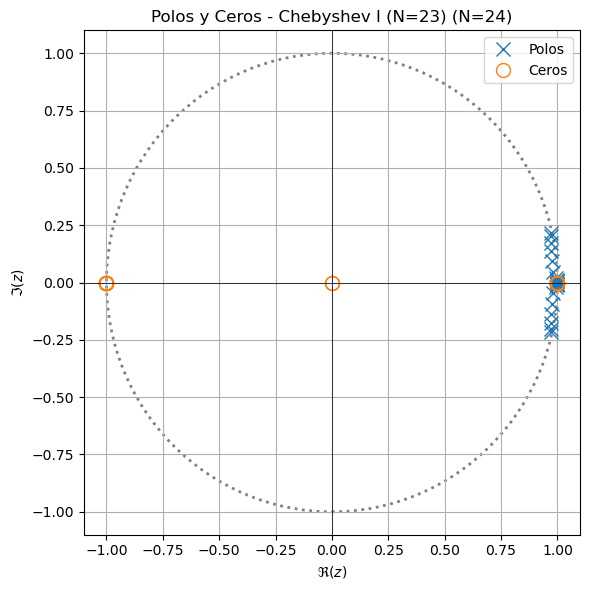

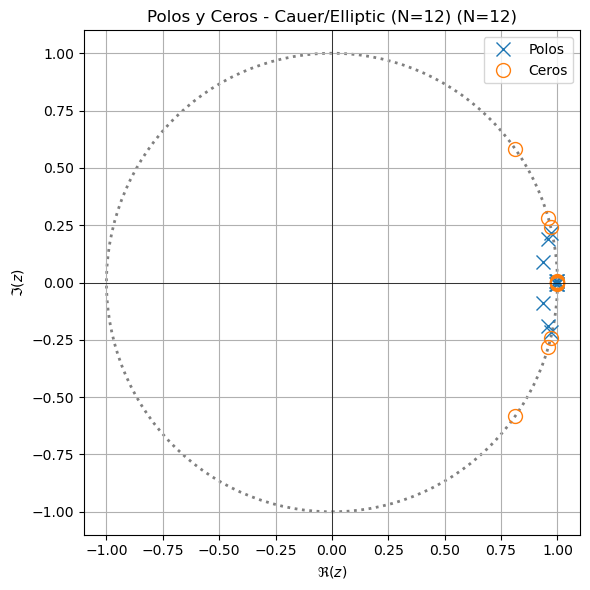

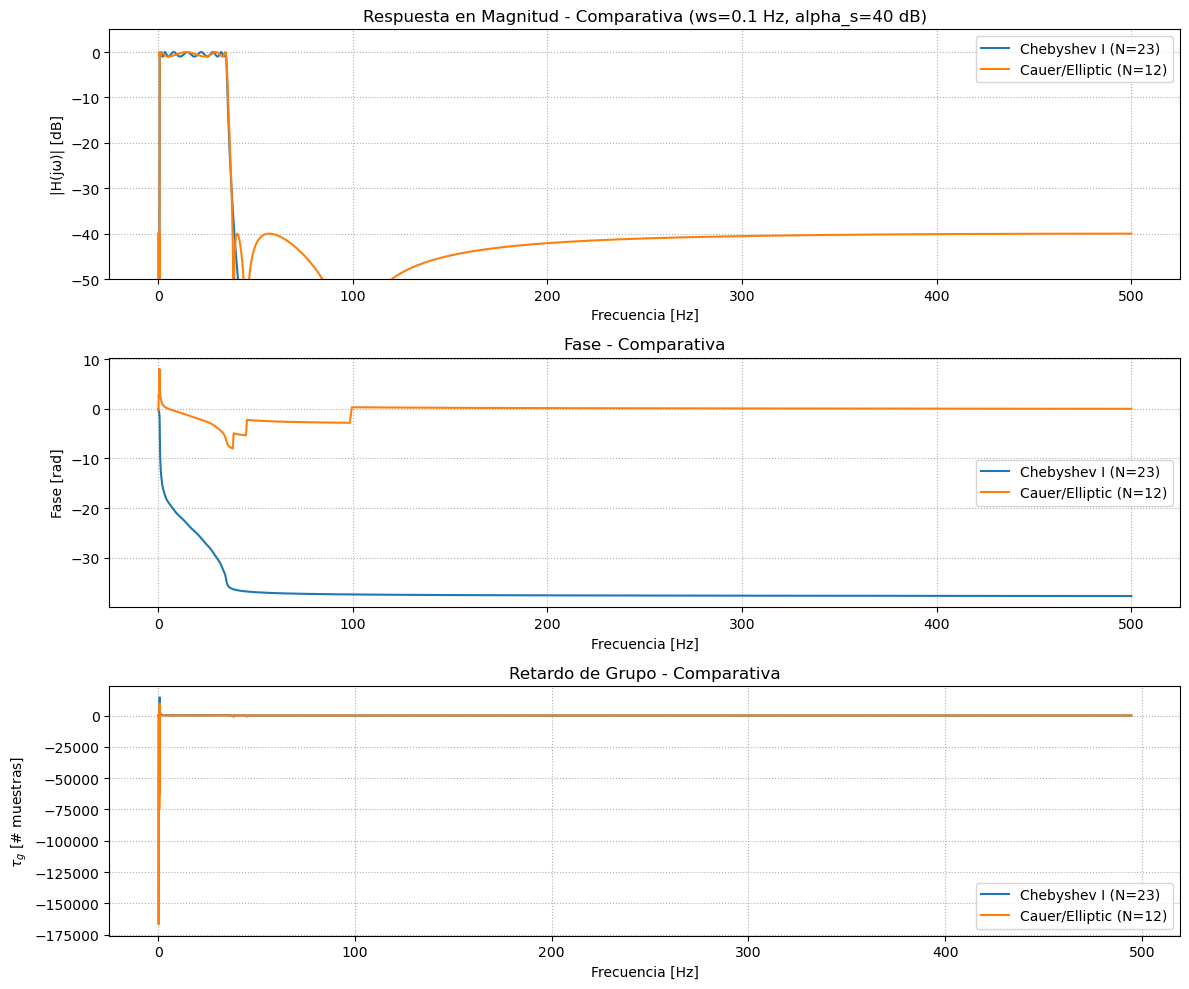

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Diseño de los filtros IIR Chebyshev I y Cauer/Elíptico.

Created on Wed Nov 12 21:48:12 2025

@author: Fernando Daniel Fiamberti
"""

import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
from matplotlib import patches
import warnings
import sys
import io

# -------------------------------------------------------------
# 1. Parámetros Generales
# -------------------------------------------------------------
fs = 1000 # Hz

# === ESPECIFICACIONES ===
wp = (0.8, 35) # Frecuencia de corte/paso (Hz)
ws = (0.1, 40) # Frecuencia de stop/detenida (Hz) 
alpha_p = 1 # Atenuación máxima en banda de paso (dB)
alpha_s = 40 # Atenuación mínima en banda de atenuación (dB)
# =============================================================

filtros = {}

# -------------------------------------------------------------
# 2. Diseño de los Filtros
# -------------------------------------------------------------

falso_stderr = io.StringIO()

old_stderr = sys.stderr

try:
    sys.stderr = falso_stderr
    N_butt, wn_butt = sig.buttord(wp, ws, alpha_p, alpha_s, analog=False, fs=fs)
    mi_sos_butt = sig.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s,analog=False, ftype='butter', output='sos', fs=fs)
finally:
    sys.stderr = old_stderr
filtros['Butterworth (N=76)'] = mi_sos_butt


# --- Diseño Chebyshev Tipo I (N ~23) ---
N_cheb1, wn_cheb1 = sig.cheb1ord(wp, ws, alpha_p, alpha_s, analog=False, fs=fs)
mi_sos_cheb1 = sig.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s,analog=False, ftype='cheby1', output='sos', fs=fs)
filtros['Chebyshev I (N=23)'] = mi_sos_cheb1


# --- Diseño Chebyshev Tipo II (N ~23) ---
N_cheb2, wn_cheb2 = sig.cheb2ord(wp, ws, alpha_p, alpha_s, analog=False, fs=fs)
mi_sos_cheb2 = sig.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s,analog=False, ftype='cheby2', output='sos', fs=fs)
filtros['Chebyshev II (N=23)'] = mi_sos_cheb2


# --- Diseño Cauer/Elíptico (Estable, N=12) ---
N_cauer, wn_cauer = sig.ellipord(wp, ws, alpha_p, alpha_s, analog=False, fs=fs)
mi_sos_cauer = sig.iirdesign(wp, ws, gpass=alpha_p, gstop=alpha_s,analog=False, ftype='ellip', output='sos', fs=fs)
filtros['Cauer/Elliptic (N=12)'] = mi_sos_cauer

# -------------------------------------------------------------
# 3. FILTRADO: Seleccionar solo Chebyshev I y Cauer/Elliptic
# -------------------------------------------------------------
filtros_a_mostrar = ['Chebyshev I (N=23)', 'Cauer/Elliptic (N=12)']

# -------------------------------------------------------------
# 4. Análisis de Respuesta y Polos/Ceros (Solo filtros seleccionados)
# -------------------------------------------------------------
resultados = {}

# Suprime las advertencias de BadCoefficients en esta sección
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=sig.BadCoefficients) # Ignorar advertencias específicas de SciPy

    for name, mi_sos in filtros.items():
        if name not in filtros_a_mostrar:
            continue # Ignorar los filtros no seleccionados
        
        # --- Respuesta en frecuencia ---
        w, h = sig.sosfreqz(mi_sos, worN=np.logspace(np.log10(0.01), np.log10(fs/2), 1000), fs = fs) 

        # --- Cálculo de fase y retardo de grupo ---
        phase = np.unwrap(np.angle(h))
        w_rad = w / (fs/2) * np.pi
        gd = -np.diff(phase) / np.diff(w_rad)

        # --- Polos y ceros ---
        z, p, k = sig.sos2zpk(mi_sos)
        order = mi_sos.shape[0] * 2
        

        resultados[name] = {'w': w, 'h': h, 'phase': phase, 'gd': gd, 'z': z, 'p': p, 'order': order}

        # Diagrama de polos y ceros individual
        plt.figure(figsize=(6,6))
        plt.plot(np.real(p), np.imag(p), 'x', markersize=10, label='Polos' )
        if len(z) > 0:
            plt.plot(np.real(z), np.imag(z), 'o', markersize=10, fillstyle='none', label='Ceros')
        
        axes_hdl = plt.gca()
        unit_circle = patches.Circle((0, 0), radius=1, fill=False, color='gray', ls='dotted', lw=2)
        axes_hdl.add_patch(unit_circle)

        plt.axhline(0, color='k', lw=0.5)
        plt.axvline(0, color='k', lw=0.5)
        plt.axis([-1.1, 1.1, -1.1, 1.1])
        plt.title(f'Polos y Ceros - {name} (N={order})')
        plt.xlabel(r'$\Re(z)$')
        plt.ylabel(r'$\Im(z)$')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ----------------------------------------------------------------------------------------
# 5. Gráficas Comparativas (Magnitud, Fase, Retardo de Grupo - Solo los seleccionados)
# ----------------------------------------------------------------------------------------

plt.figure(figsize=(12, 10))
eps = 1e-8 # Piso numérico para evitar log10(0)

# Magnitud
plt.subplot(3,1,1)
for name, res in resultados.items():
    plt.plot(res['w'], 20*np.log10(abs(res['h']) + eps), label = name)
plt.title(f'Respuesta en Magnitud - Comparativa (ws={ws[0]} Hz, alpha_s={alpha_s} dB)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.ylim([-50, 5]) 
plt.grid(True, which='both', ls=':')
plt.legend()
 
# Fase
plt.subplot(3,1,2)
for name, res in resultados.items():
    plt.plot(res['w'], res['phase'], label = name)
plt.title('Fase - Comparativa')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid(True, which='both', ls=':')
plt.legend()

# Retardo de grupo
plt.subplot(3,1,3)
for name, res in resultados.items():
    # El retardo de grupo tiene un elemento menos que 'w'
    plt.plot(res['w'][:-1], res['gd'], label = name) 
plt.title('Retardo de Grupo - Comparativa')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel(r'$\tau_g$ [# muestras]')
plt.grid(True, which='both', ls=':')
plt.legend()

plt.tight_layout()
plt.show()

# Diseño de los filtros FIR

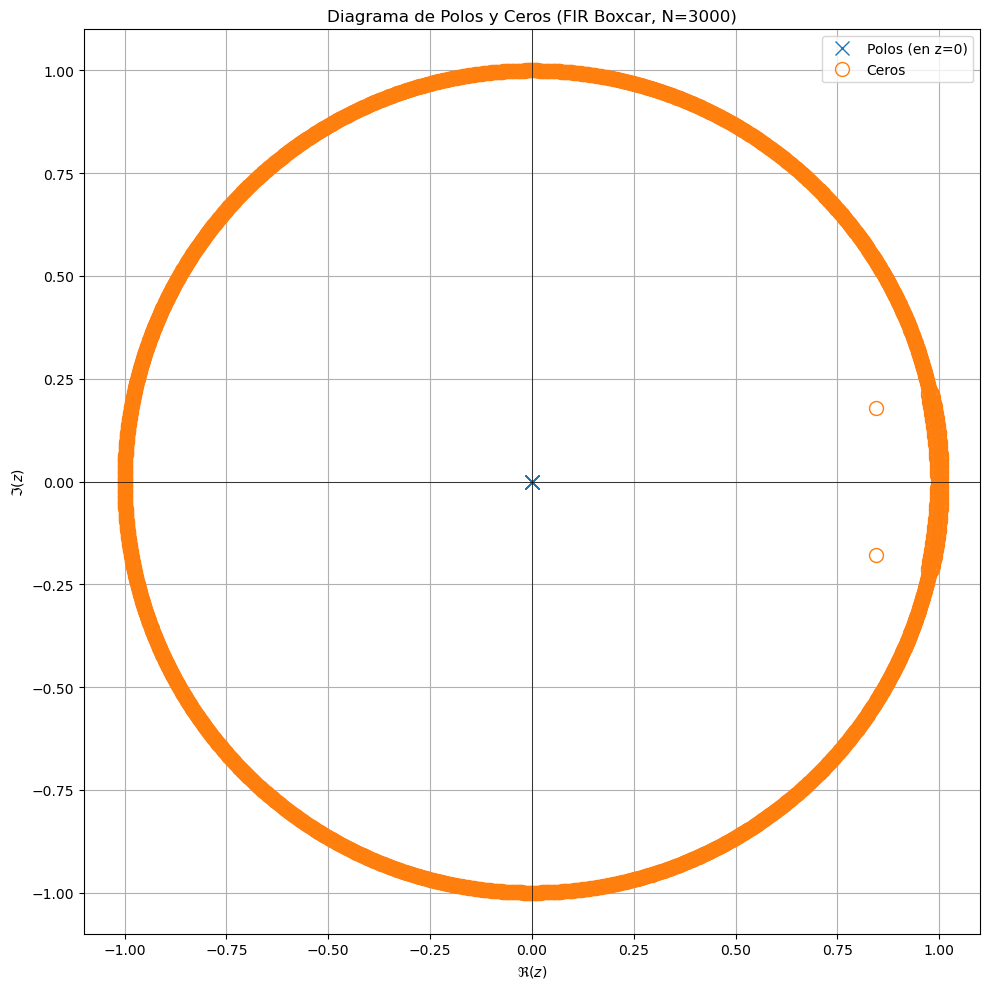

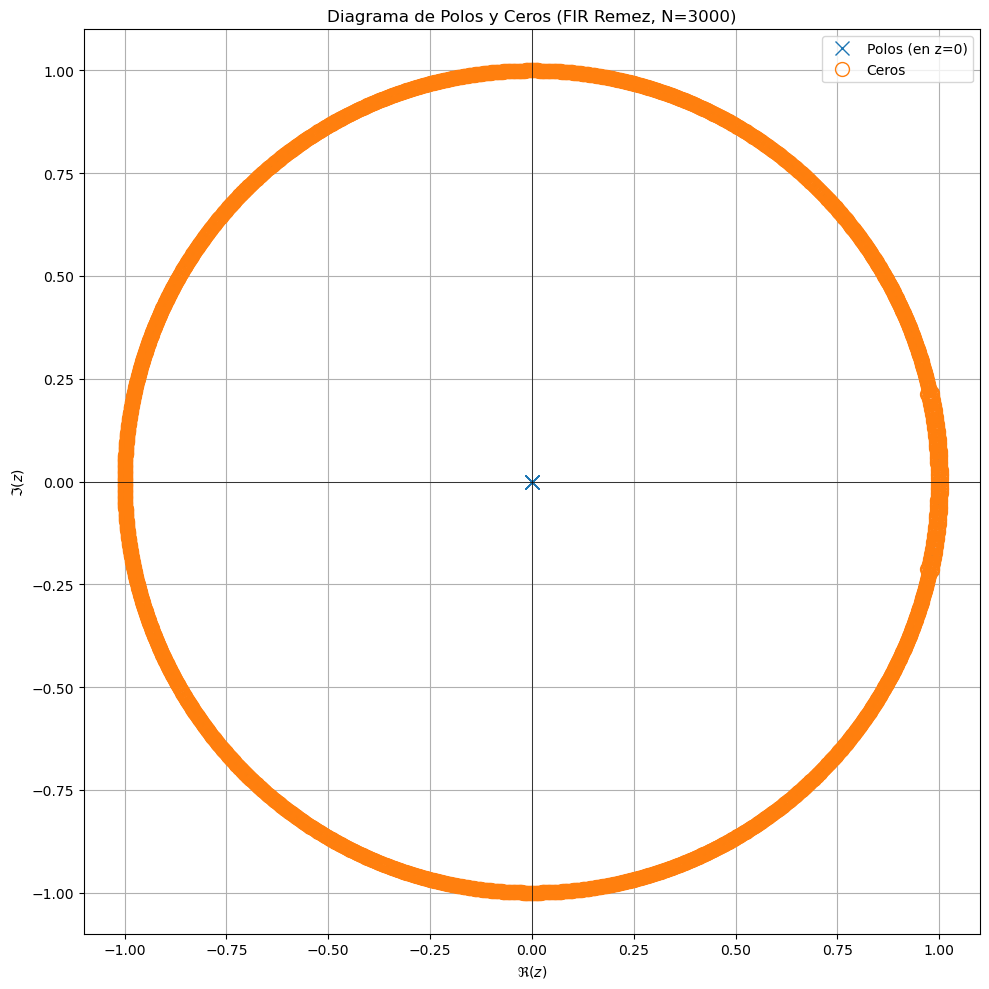

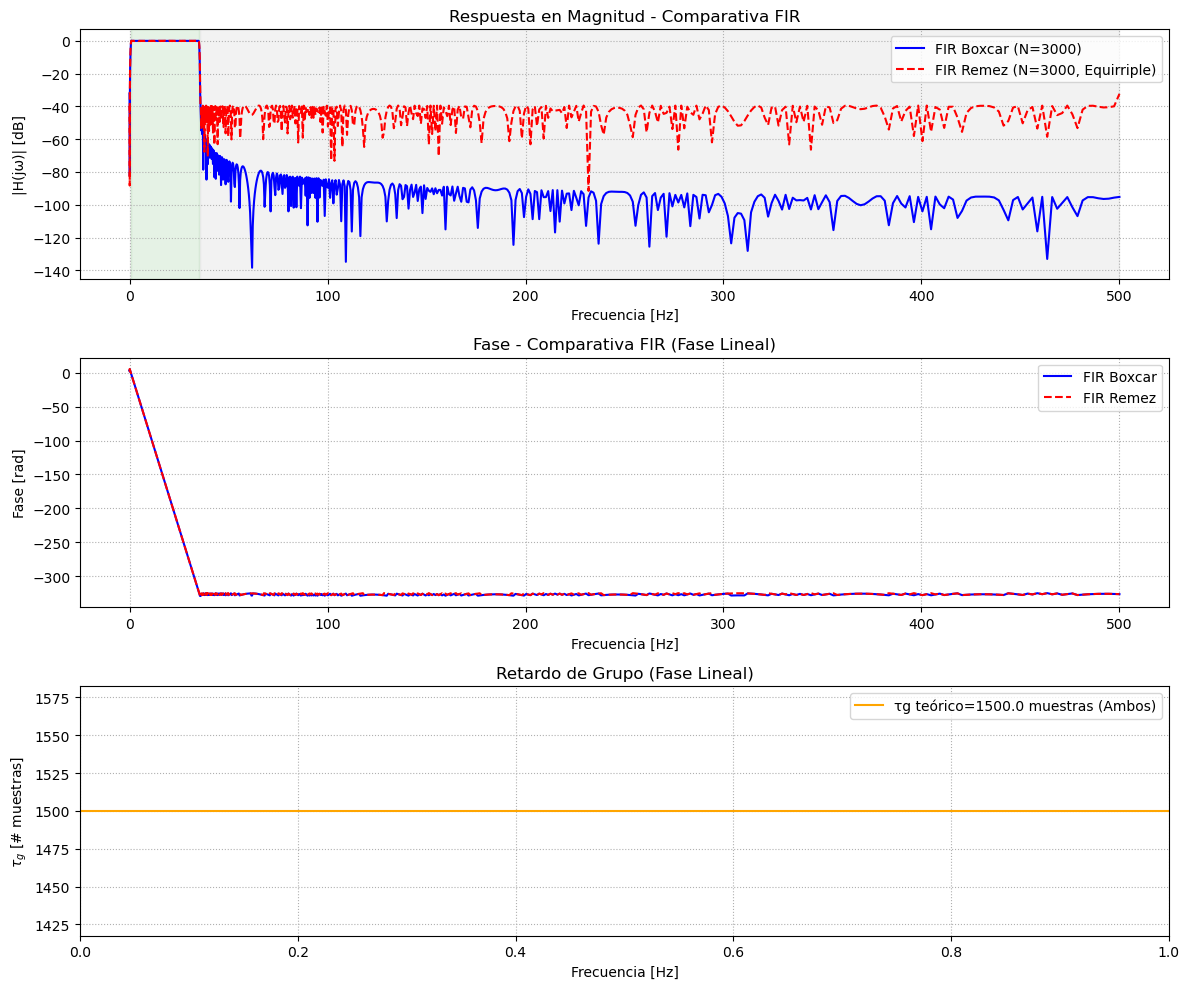

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Diseño de dos filtros FIR: Ventana Rectangular (Boxcar) y Remez/Parks-McClellan.

Created on Wed Nov 12 21:57:34 2025

@author: Fernando Daniel Fiamberti
"""

import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
from matplotlib import patches
import sys

# --- Parámetros Generales ---
fs = 1000 # Hz (Frecuencia de muestreo)
N = 3000   # Orden del filtro (Número de coeficientes - 1)
numtaps = N + 1 # Número de coeficientes/taps

wp = (0.8 , 35 )  # Frecuencia de corte/paso (Hz)
#-----------------------------
# PREDISTORSION
#-----------------------------
delta0 = 0
delta1 = 0.1

ws0 = 0.1 
ws1 = 35.7 

ws = (ws0, ws1 )    # Frecuencia de stop/detenida (Hz)
#-----------------------------


# -------------------------------------------------------------
# 1. Definición de la Plantilla y Bandas (Común a ambos filtros)
# -------------------------------------------------------------
# Plantilla de sig.firwin2 (solo se usa para Boxcar)
f_deseada = [
    0,               
    ws[0] + delta1,        
    wp[0],          
    wp[1],          
    ws[1] - delta1,        
    fs / 2          
]

m_deseada = [
    0, 0, 1, 1, 0, 0
]

# Bandas para sig.remez (necesita las frecuencias de transición en pares)
# El diseño remez usa la frecuencia normalizada (0 a fs/2), pero podemos usar fs=fs
f_remez = [0, ws[0], wp[0], wp[1], ws[1], fs/2]

# Magnitudes deseadas para remez (Bandas de detención 0, Banda de paso 1)
a_remez = [0, 1, 0] 


# -------------------------------------------------------------
# 2. Diseño del Filtro FIR 1 (Ventana Rectangular -> Boxcar)
# -------------------------------------------------------------
# b_boxcar es el arreglo de coeficientes
b_boxcar = sig.firwin2(numtaps=numtaps, freq=f_deseada, gain=m_deseada, fs=fs, window='boxcar')

# --- Respuesta en frecuencia (Boxcar) ---
w, H_boxcar = sig.freqz(b_boxcar, a=1, worN=np.logspace(-2,np.log10(fs/2),2000), fs=fs)

# --- Cálculo de fase y retardo de grupo (Boxcar) ---
phase_boxcar = np.unwrap(np.angle(H_boxcar))
gd_esperado = N / 2 
w_rad = w / (fs/2) * np.pi
gd_boxcar = -np.diff(phase_boxcar) / np.diff(w_rad)

# --- Polos y ceros (Boxcar) ---
z_boxcar = np.roots(b_boxcar)
p_boxcar = np.zeros(N)


# -------------------------------------------------------------
# 3. Diseño del Filtro FIR 2 (Remez/Parks-McClellan)
# -------------------------------------------------------------
# El diseño Remez utiliza el algoritmo equirriple, que optimiza el rizado.
# Nota: La función remez espera las bandas en pares [banda_detencion, banda_paso, banda_detencion...]
b_remez = sig.remez(numtaps=numtaps, bands=f_remez, desired=a_remez, fs=fs, type='bandpass')

# --- Respuesta en frecuencia (Remez) ---
w_r, H_remez = sig.freqz(b_remez, a=1, worN=np.logspace(-2,np.log10(fs/2),2000), fs=fs)

# --- Cálculo de fase y retardo de grupo (Remez) ---
phase_remez = np.unwrap(np.angle(H_remez))
gd_remez = -np.diff(phase_remez) / np.diff(w_rad) 

# --- Polos y ceros (Remez) ---
z_remez = np.roots(b_remez)
p_remez = np.zeros(N)


# -------------------------------------------------------------
# 4. Diagramas de Polos y Ceros
# -------------------------------------------------------------

# --- Función auxiliar para graficar Polos/Ceros ---
def plot_pz(z, p, title, order):
    plt.figure(figsize=(10,10))
    plt.plot(np.real(p), np.imag(p), 'x', markersize=10, label='Polos (en z=0)' )
    axes_hdl = plt.gca()
    if len(z) > 0:
        plt.plot(np.real(z), np.imag(z), 'o', markersize=10, fillstyle='none', label='Ceros')
    plt.axhline(0, color='k', lw=0.5)
    plt.axvline(0, color='k', lw=0.5)
    unit_circle = patches.Circle((0, 0), radius=1, fill=False, color='gray', ls='dotted', lw=2)
    axes_hdl.add_patch(unit_circle)
    plt.axis([-1.1, 1.1, -1.1, 1.1])
    plt.title(f'Diagrama de Polos y Ceros ({title}, N={order})')
    plt.xlabel(r'$\Re(z)$')
    plt.ylabel(r'$\Im(z)$')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pz(z_boxcar, p_boxcar, 'FIR Boxcar', N)
plot_pz(z_remez, p_remez, 'FIR Remez', N)


# -------------------------------------------------------------
# 5. Gráficas Comparativas
# -------------------------------------------------------------
plt.figure(figsize=(12,10))
eps = 1e-8 

# Magnitud
plt.subplot(3,1,1)
plt.plot(w, 20*np.log10(abs(H_boxcar) + eps), label = f'FIR Boxcar (N={N})', color='blue')
plt.plot(w_r, 20*np.log10(abs(H_remez) + eps), label = f'FIR Remez (N={N}, Equirriple)', color='red', linestyle='--')
plt.title('Respuesta en Magnitud - Comparativa FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')

# Dibujar las bandas requeridas (Regiones de la plantilla)
plt.axvspan(0, ws[0], color='gray', alpha=0.1)      
plt.axvspan(wp[0], wp[1], color='green', alpha=0.1) 
plt.axvspan(ws[1], fs/2, color='gray', alpha=0.1)   

plt.grid(True, which='both', ls=':')
plt.legend()

 
# Fase
plt.subplot(3,1,2)
plt.plot(w, phase_boxcar, label = 'FIR Boxcar', color='blue')
plt.plot(w_r, phase_remez, label = 'FIR Remez', color='red', linestyle='--')
plt.title('Fase - Comparativa FIR (Fase Lineal)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid(True, which='both', ls=':')
plt.legend()


# Retardo de grupo
plt.subplot(3,1,3)
# El retardo de grupo es el mismo N/2 para ambos filtros de fase lineal
plt.axhline(gd_esperado, color='orange', linestyle='-', label=f'τg teórico={gd_esperado:.1f} muestras (Ambos)')
plt.title('Retardo de Grupo (Fase Lineal)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel(r'$\tau_g$ [# muestras]')
plt.grid(True, which='both', ls=':')
plt.legend()


plt.tight_layout()
plt.show()

# Señal ECG original y filtrada
## Comparación de los cuatro filtros diseñados

Cargando ecg.mat...
Cargadas 600000 muestras de ECG con ruido.
Aplicando filtro: FIR Boxcar...
Aplicando filtro: FIR Parks-McClellan...
Aplicando filtro: IIR Chebyshev I...
Aplicando filtro: IIR Cauer/Elíptico...

--- Filtrado Completado para los 4 Diseños. ---


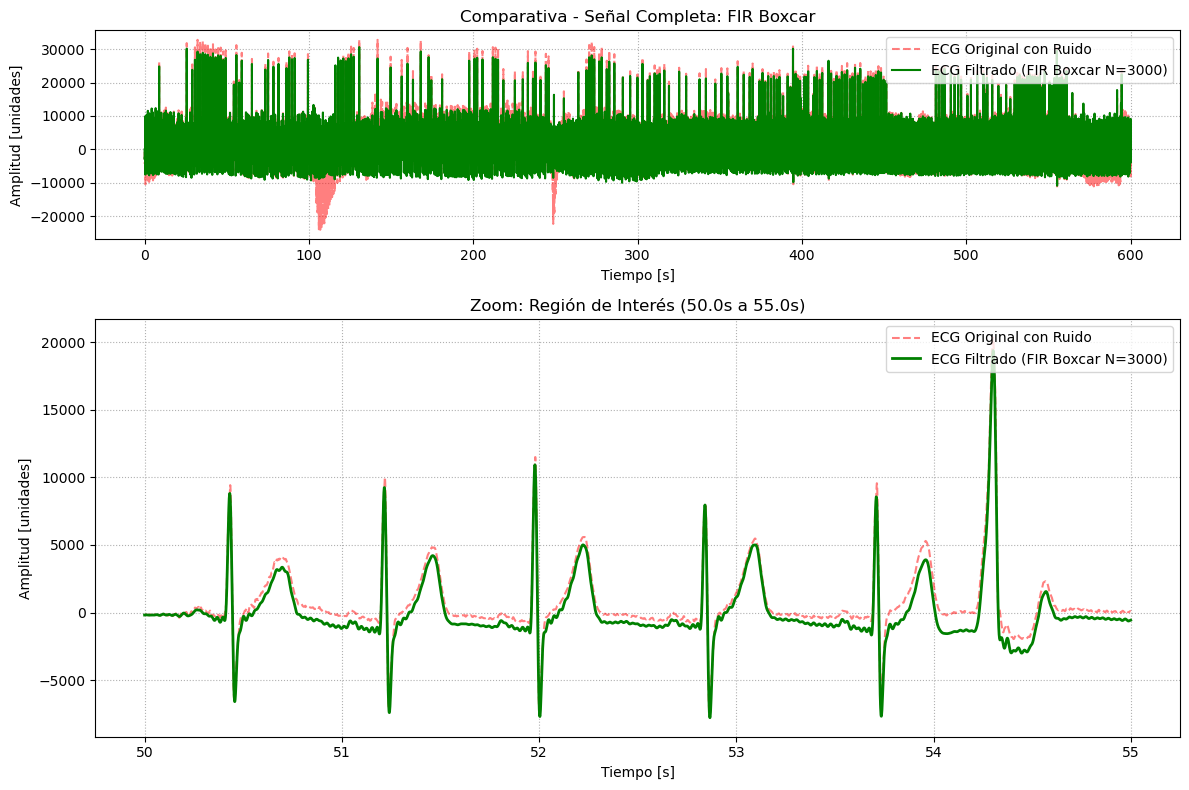

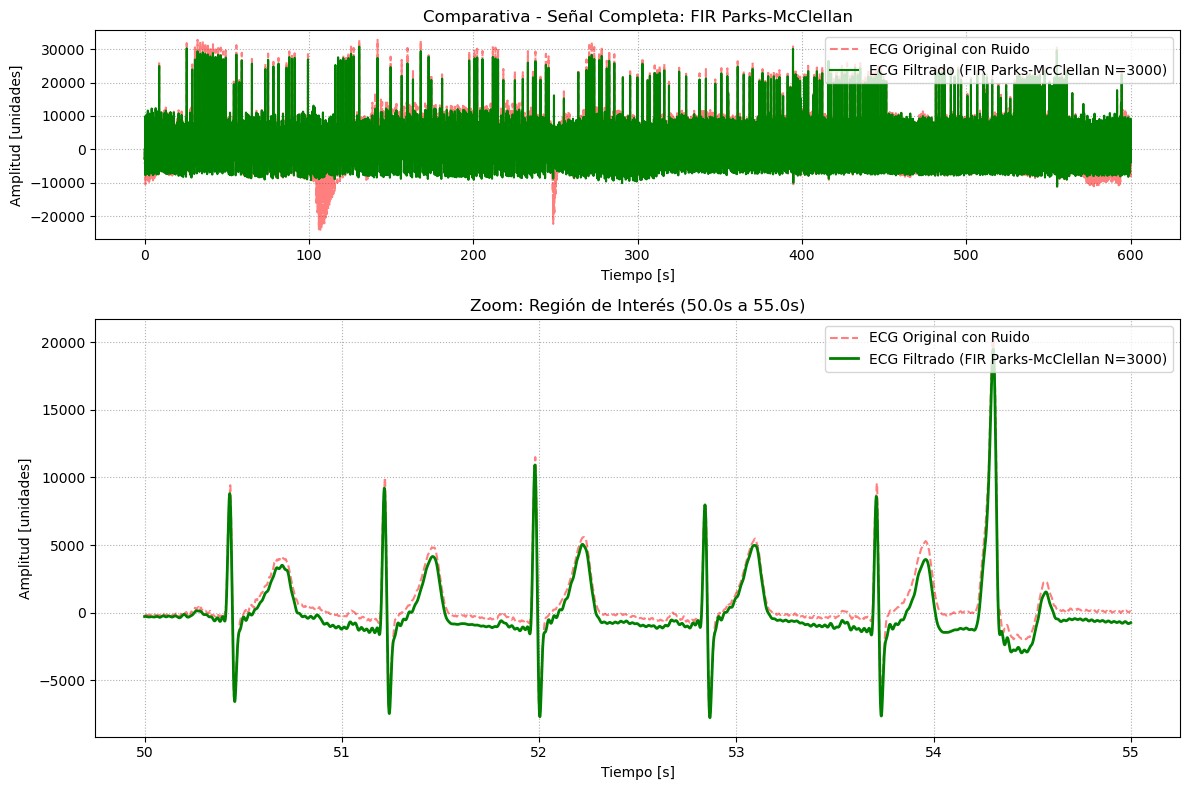

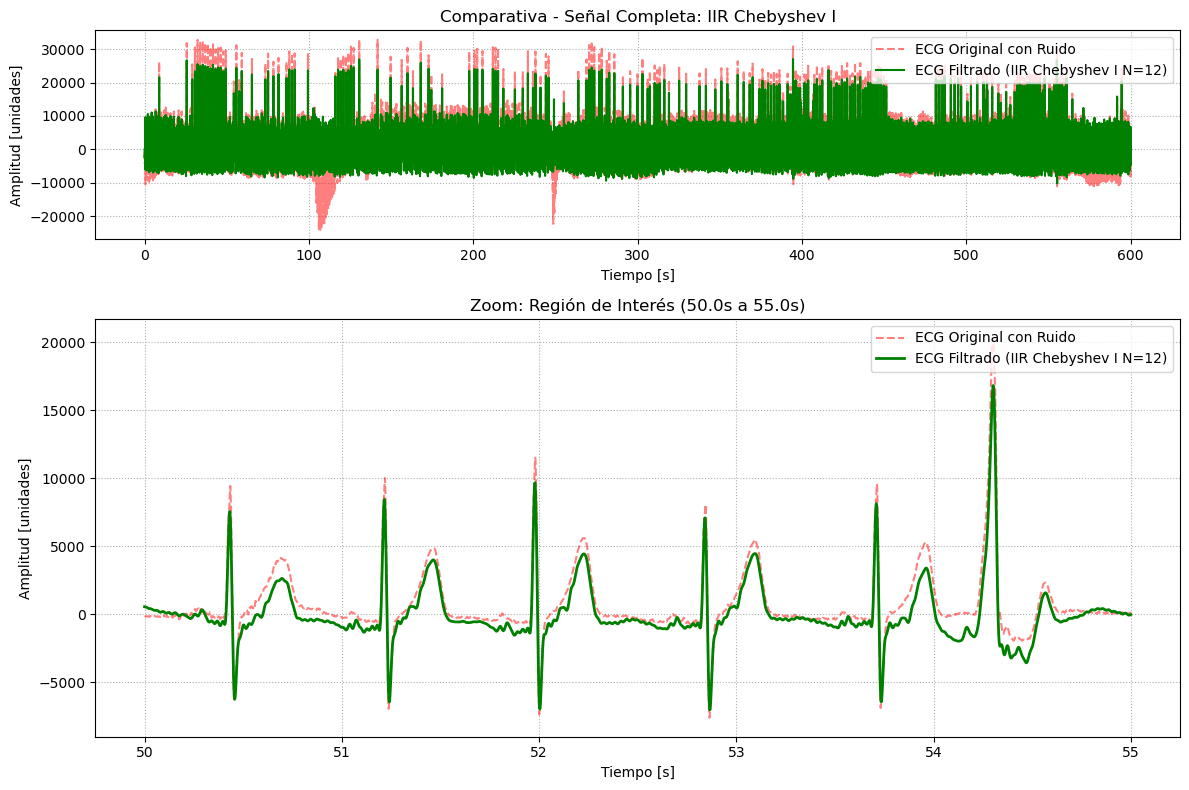

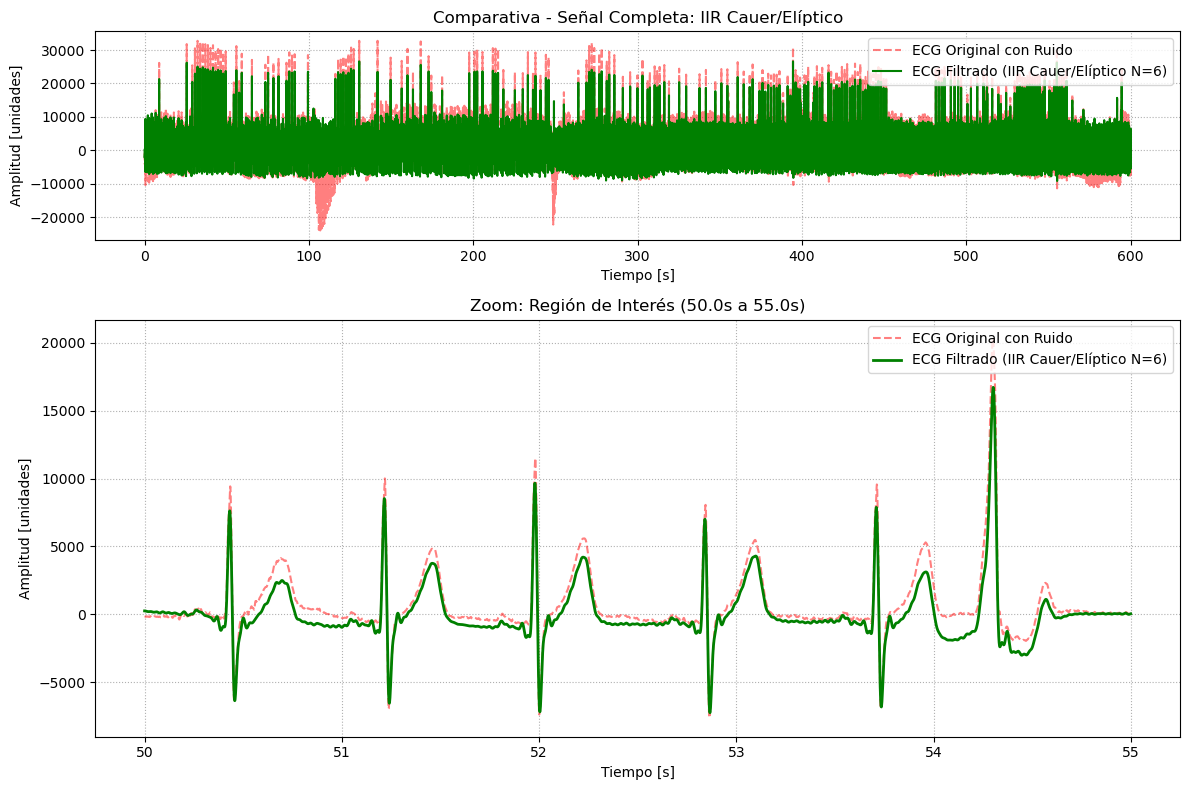

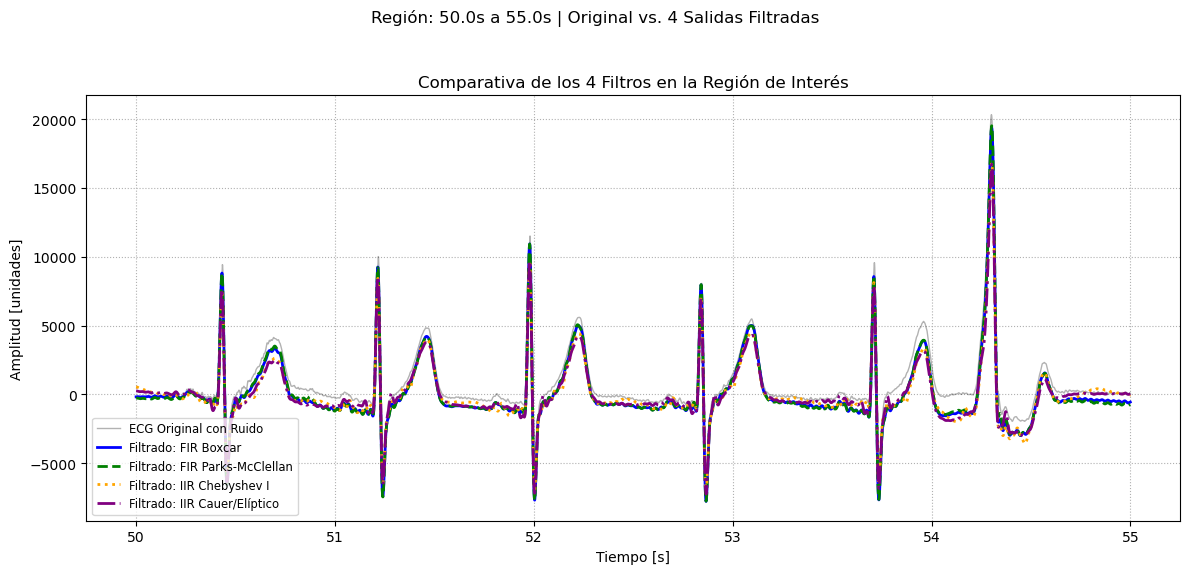


--- Generando Gráficos de Verificación de Respuesta en Frecuencia (Punto c) ---


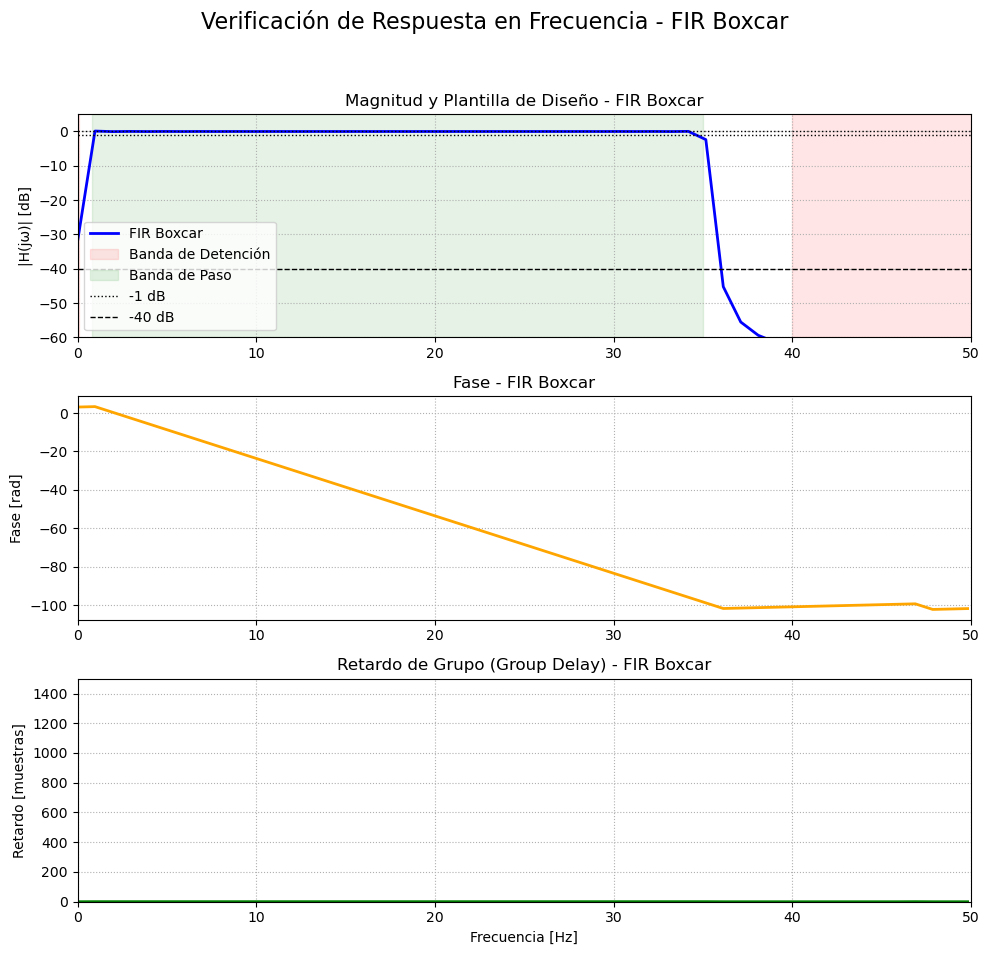

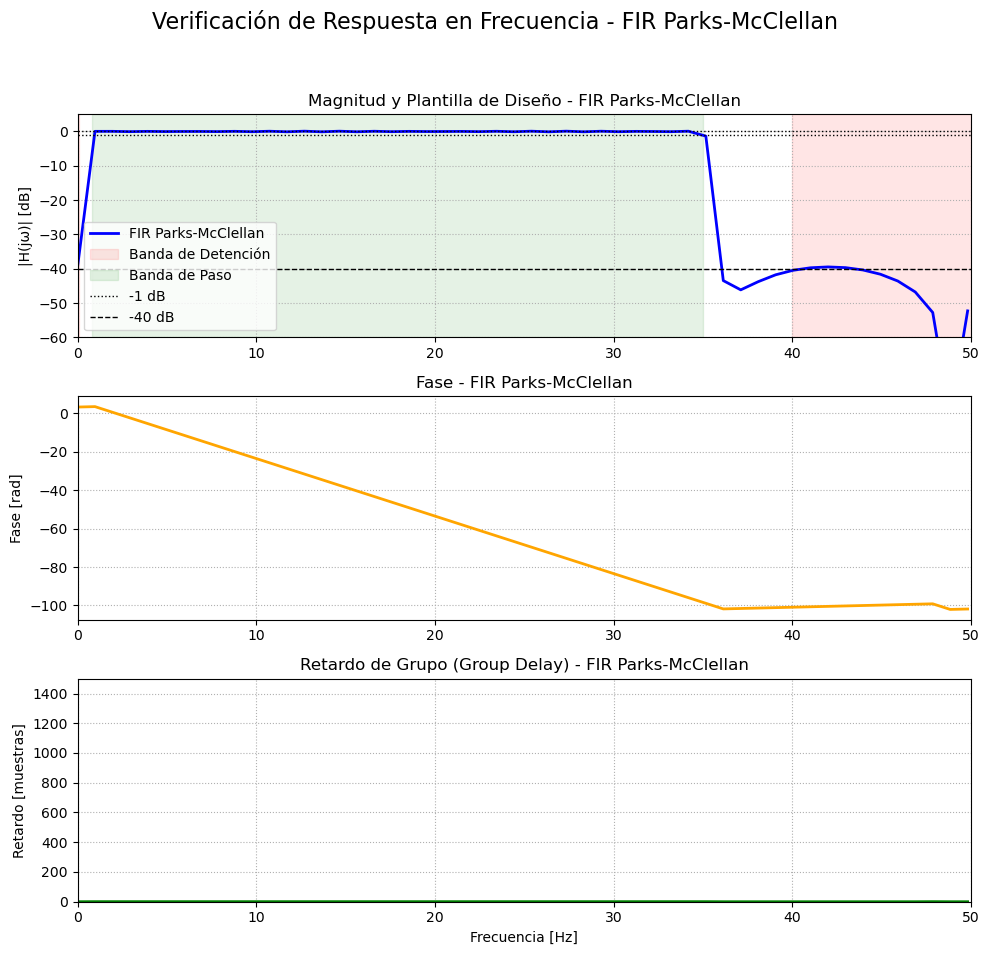

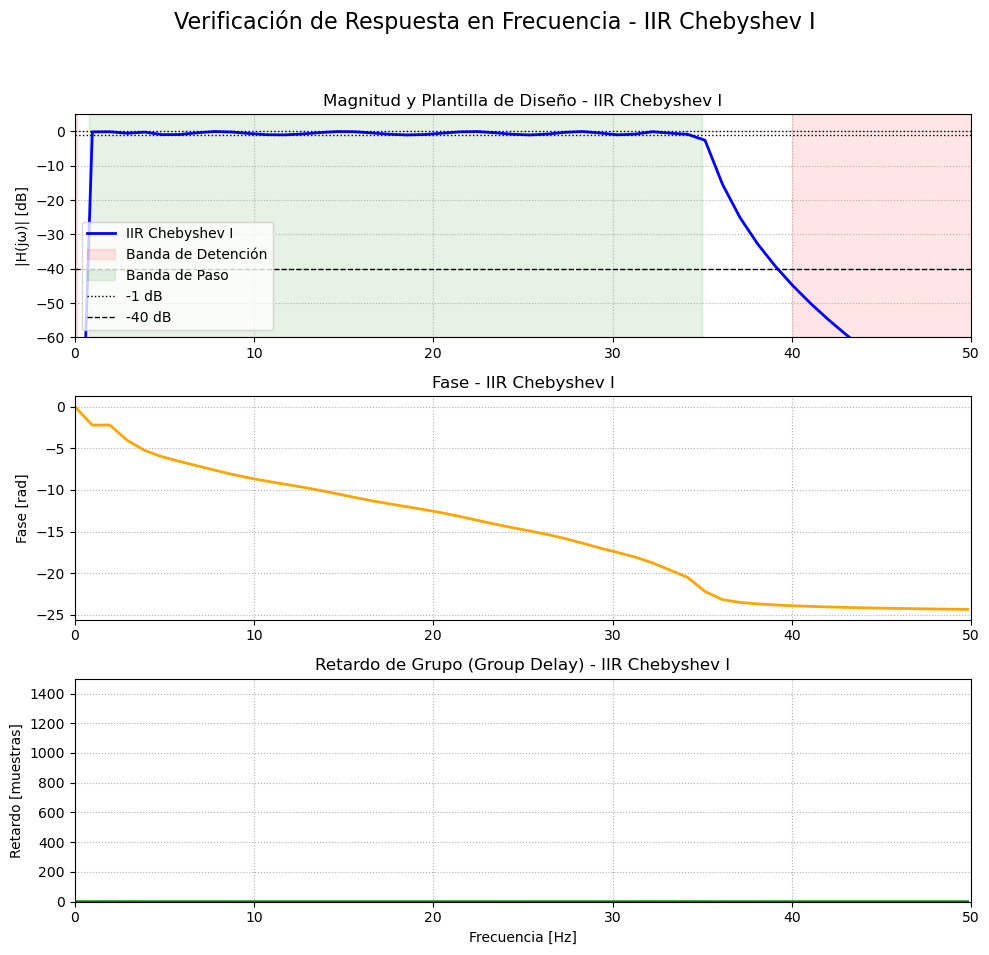

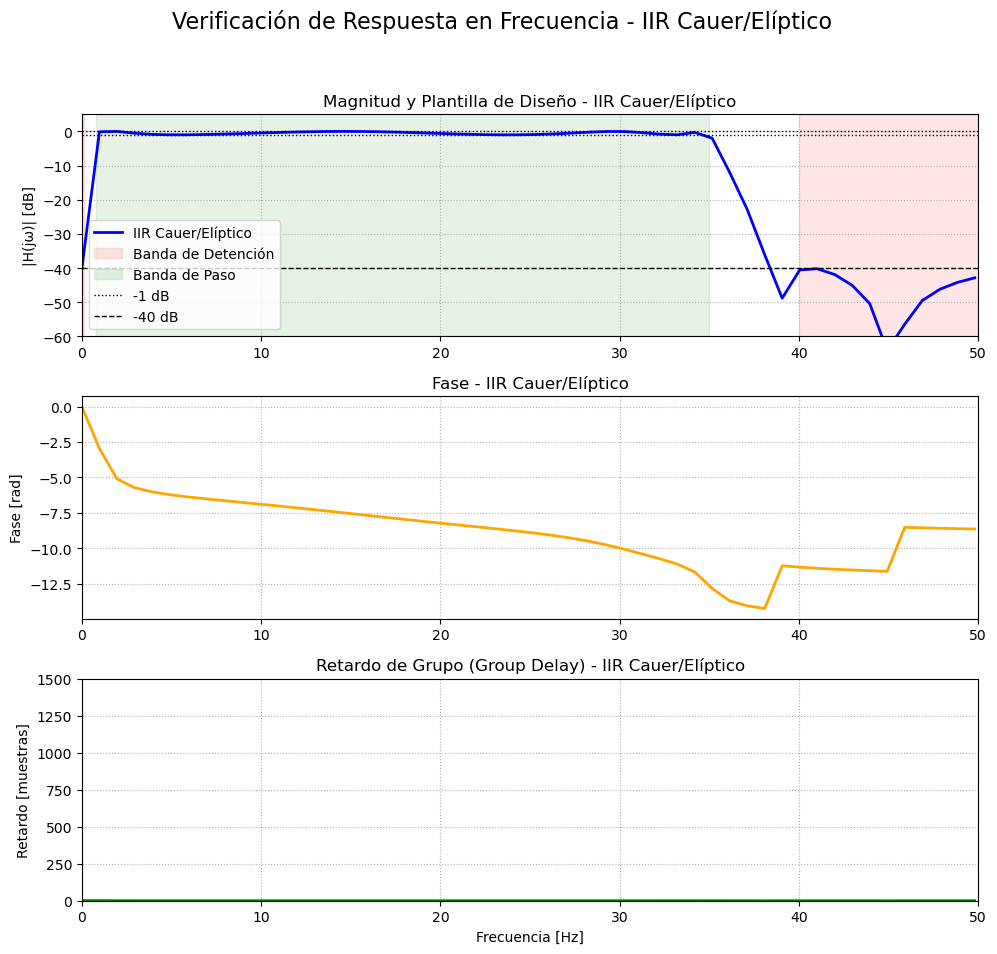

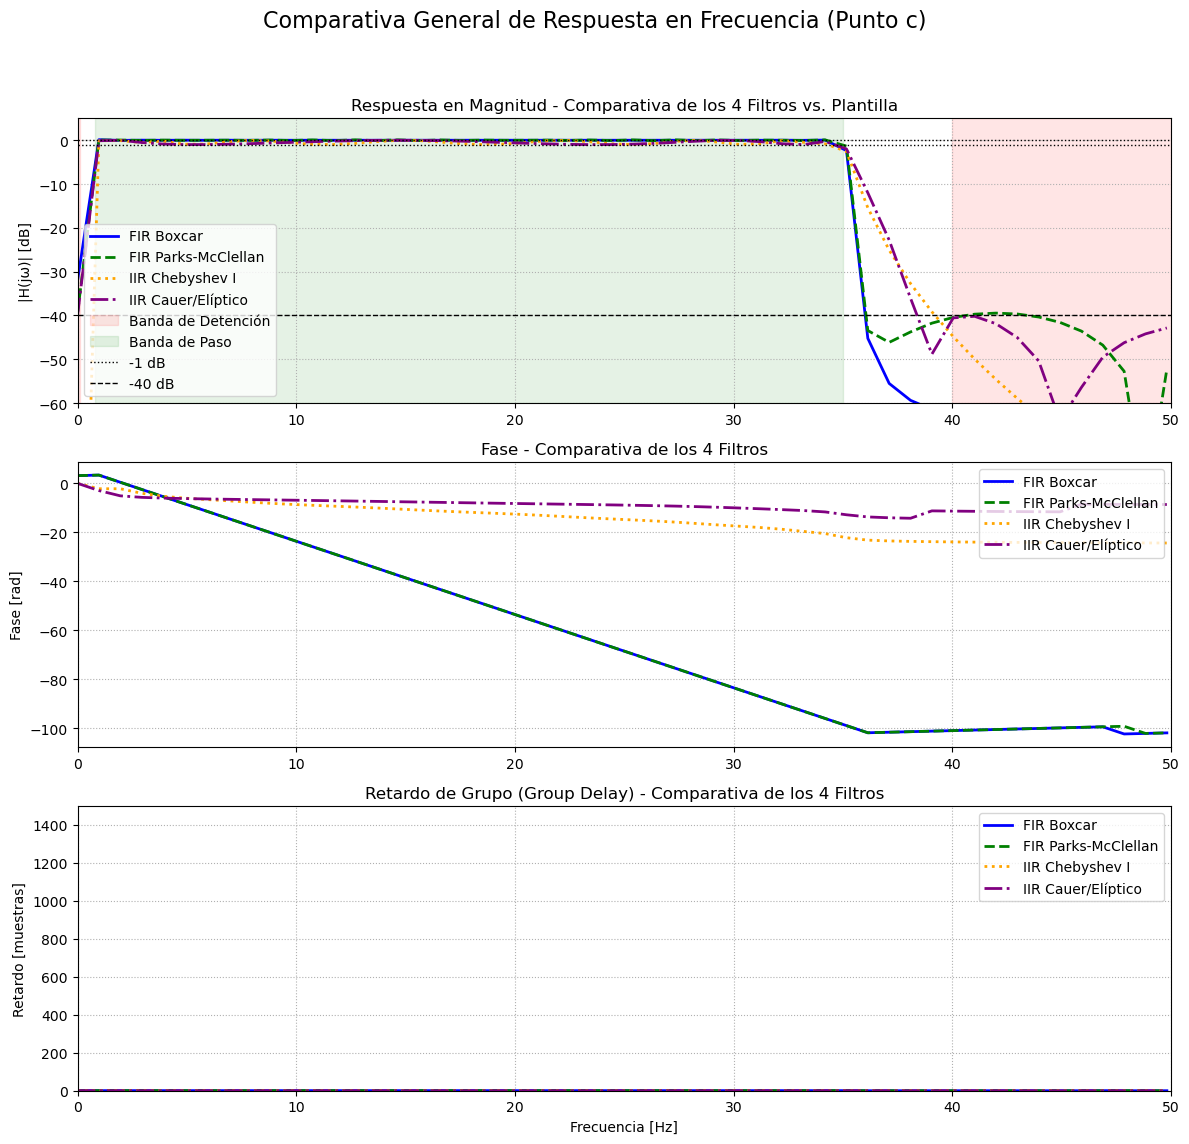


--- ¡Ejecución Completa!


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Aplica, evalúa y verifica la Respuesta en Frecuencia (Punto c).

Created on Wed Nov 12 22:05:31 2025

@author: Fernando Daniel Fiamberti
"""


import numpy as np
from scipy import signal as sig
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings
import sys

# =========================================================================
# 1. Parámetros de Carga de Datos y Diseño
# =========================================================================

# Parámetros de carga
DATA_FILENAME = 'ecg.mat'
DATA_KEY = 'ecg_lead'
FS = 1000 # Frecuencia de muestreo (Hz)
N_SAMPLES_TO_USE = 600000

# Parámetros de la Región de Interés
REGION_START = 50000  # Muestra de inicio
REGION_END = 55000    # Muestra de fin

# Parámetros de Diseño
fs = FS
# IIR
alpha_p = 1   # Atenuación máxima en banda de paso (dB)
alpha_s = 40  # Atenuación mínima en banda de detención (dB)
wp = (0.8, 35)      # Frecuencia de corte/paso (Hz)
ws_iir = (0.1, 40)  # Frecuencia de stop/detenida IIR (Hz)
# FIR
N_fir = 3000   # Orden del filtro FIR
numtaps_fir = N_fir + 1
delta1_fir = 0.1
ws0_fir = 0.1
ws1_fir = 35.7

# =========================================================================
# 2. Carga y Preparación de la Señal ECG con Ruido
# =========================================================================

try:
    print(f"Cargando {DATA_FILENAME}...")
    mat = sio.loadmat(DATA_FILENAME)
    ecg_ruido_full = np.squeeze(mat.get(DATA_KEY, None))
    
    if ecg_ruido_full is None:
        raise KeyError(f"La clave '{DATA_KEY}' no se encontró en {DATA_FILENAME}.")
        
    if len(ecg_ruido_full) >= N_SAMPLES_TO_USE:
         ecg_ruido_full = ecg_ruido_full[:N_SAMPLES_TO_USE]
         print(f"Cargadas {len(ecg_ruido_full)} muestras de ECG con ruido.")
    else:
        N_SAMPLES_TO_USE = len(ecg_ruido_full)
        ecg_ruido_full = ecg_ruido_full
        print(f"Advertencia: El archivo tiene menos de 600000. Usando {N_SAMPLES_TO_USE} muestras.")

except (FileNotFoundError, KeyError, ValueError) as e:
    print(f"¡Error! No se pudo cargar o procesar '{DATA_FILENAME}': {e}")
    N_SAMPLES_TO_USE = 10000 
    t = np.arange(0, N_SAMPLES_TO_USE) / FS
    ecg_ruido_full = np.sin(2 * np.pi * 1 * t) + 1.5 * np.sin(2 * np.pi * 50 * t) 
    print("Usando ECG simulado de emergencia con ruido.")

N_signal = len(ecg_ruido_full)

if REGION_END > N_signal:
    REGION_END = N_signal - 1000 
    REGION_START = max(0, REGION_END - 5000) 

# =========================================================================
# 3. Diseño de los 4 Filtros
# =========================================================================

# --- FIR Boxcar
f_deseada = [0, ws0_fir + delta1_fir, wp[0], wp[1], ws1_fir - delta1_fir, fs / 2]
m_deseada = [0, 0, 1, 1, 0, 0]
b_boxcar = sig.firwin2(numtaps=numtaps_fir, freq=f_deseada, gain=m_deseada, fs=fs, window='boxcar')

# --- FIR Parks-McClellan (Remez)
f_remez = [0, ws0_fir, wp[0], wp[1], ws1_fir, fs/2]
a_remez = [0, 1, 0] 
b_remez = sig.remez(numtaps=numtaps_fir, bands=f_remez, desired=a_remez, fs=fs, type='bandpass')

with warnings.catch_warnings():
    warnings.simplefilter("ignore", sig.BadCoefficients)
    # --- IIR Chebyshev I
    N_cheb1, _ = sig.cheb1ord(wp, ws_iir, alpha_p, alpha_s, analog=False, fs=fs)
    mi_sos_cheb1 = sig.iirdesign(wp, ws_iir, gpass=alpha_p, gstop=alpha_s, 
                             analog=False, ftype='cheby1', output='sos', fs=fs)
    # --- IIR Cauer/Elíptico
    N_cauer, _ = sig.ellipord(wp, ws_iir, alpha_p, alpha_s, analog=False, fs=fs)
    mi_sos_cauer = sig.iirdesign(wp, ws_iir, gpass=alpha_p, gstop=alpha_s, 
                             analog=False, ftype='ellip', output='sos', fs=fs)

# =========================================================================
# 4. Aplicación de Filtrado
# =========================================================================

FILTROS = {
    'FIR Boxcar': {'b': b_boxcar, 'a': 1, 'type': 'FIR', 'design_info': f'N={N_fir}'},
    'FIR Parks-McClellan': {'b': b_remez, 'a': 1, 'type': 'FIR', 'design_info': f'N={N_fir}'},
    'IIR Chebyshev I': {'sos': mi_sos_cheb1, 'type': 'IIR', 'design_info': f'N={N_cheb1}'},
    'IIR Cauer/Elíptico': {'sos': mi_sos_cauer, 'type': 'IIR', 'design_info': f'N={N_cauer}'}
}

ecg_filtrado = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", sig.BadCoefficients)
    
    for name, params in FILTROS.items():
        print(f"Aplicando filtro: {name}...")
        
        if params['type'] == 'FIR':
            ecg_filtrado[name] = sig.filtfilt(params['b'], params['a'], ecg_ruido_full)
            
        elif params['type'] == 'IIR':
            ecg_filtrado[name] = sig.sosfiltfilt(params['sos'], ecg_ruido_full)

print("\n--- Filtrado Completado para los 4 Diseños. ---")

# =========================================================================
# 5. Visualización de Resultados (Evaluación - Punto d)
# =========================================================================

# --- 5.1, 5.2 y 5.3 Gráficas de Señal ---

for name, ecg_f in ecg_filtrado.items():
    design_info = FILTROS[name]['design_info']
    plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 1, height_ratios=[1, 2])
    
    # Subplot 1: Señal Completa
    plt.subplot(gs[0])
    t_full = np.arange(N_signal) / FS
    plt.plot(t_full, ecg_ruido_full, label='ECG Original con Ruido', color='red', alpha=0.5, linestyle='--')
    plt.plot(t_full, ecg_f, label=f'ECG Filtrado ({name} {design_info})', color='green', linewidth=1.5)
    plt.title(f'Comparativa - Señal Completa: {name}') 
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud [unidades]')
    plt.grid(True, which='both', ls=':')
    plt.legend(loc='upper right') 
    
    # Subplot 2: Región de Interés (Zoom)
    plt.subplot(gs[1])
    idx_zoom = np.arange(REGION_START, REGION_END)
    t_zoom = idx_zoom / FS
    plt.plot(t_zoom, ecg_ruido_full[idx_zoom], label='ECG Original con Ruido', color='red', alpha=0.5, linestyle='--')
    plt.plot(t_zoom, ecg_f[idx_zoom], label=f'ECG Filtrado ({name} {design_info})', color='green', linewidth=2)
    plt.title(f'Zoom: Región de Interés ({REGION_START/FS:.1f}s a {REGION_END/FS:.1f}s)')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud [unidades]')
    plt.grid(True, which='both', ls=':')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Gráfica de Comparativa General de la Región de Interés
plt.figure(figsize=(12, 6))
idx_zoom = np.arange(REGION_START, REGION_END)
t_zoom = idx_zoom / FS
plt.plot(t_zoom, ecg_ruido_full[idx_zoom], label='ECG Original con Ruido', color='black', alpha=0.3, linestyle='-', linewidth=1)
colores_comp = ['blue', 'green', 'orange', 'purple']
estilos_comp = ['-', '--', ':', '-.']
i = 0
for name, ecg_f in ecg_filtrado.items():
    plt.plot(t_zoom, ecg_f[idx_zoom], 
             label=f'Filtrado: {name}', color=colores_comp[i], linestyle=estilos_comp[i], linewidth=2)
    i += 1
plt.title(f'Comparativa de los 4 Filtros en la Región de Interés')
plt.suptitle(f'Región: {REGION_START/FS:.1f}s a {REGION_END/FS:.1f}s | Original vs. 4 Salidas Filtradas')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [unidades]')
plt.grid(True, which='both', ls=':')
plt.legend(loc='lower left', fontsize='small')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# =========================================================================
# 6. Verificación de la Respuesta en Frecuencia (Punto c)
# =========================================================================

print("\n--- Generando Gráficos de Verificación de Respuesta en Frecuencia (Punto c) ---")

# --- 6.1 Cálculo de la Respuesta en Frecuencia y Plantilla ---
respuestas = {}
eps = 1e-8
for name, params in FILTROS.items():
    if params['type'] == 'FIR':
        w, h = sig.freqz(params['b'], params['a'], fs=fs)
    elif params['type'] == 'IIR':
        w, h = sig.sosfreqz(params['sos'], fs=fs)
    
    # Calcular fase y retardo de grupo
    fase = np.unwrap(np.angle(h))
    # w * 2 * np.pi convierte w de Hz a rad/s
    group_delay = -np.diff(fase) / np.diff(w * 2 * np.pi) 
    
    respuestas[name] = {'w': w, 'h': h, 'fase': fase, 'group_delay': group_delay}

# Definición de la Plantilla de Diseño (Límites en dB)
limite_p_max = 20*np.log10(1 + eps)
limite_p_min = -alpha_p
limite_s_max = -alpha_s

# --- 6.2 Función de Ploteo Individual de la Plantilla ---
def plot_plantilla(ax):
    # Dibuja las bandas requeridas (PLANTILLA)
    ax.axvspan(0, ws_iir[0], color='red', alpha=0.1, label='Banda de Detención')
    ax.axvspan(wp[0], wp[1], color='green', alpha=0.1, label='Banda de Paso')
    ax.axvspan(ws_iir[1], fs/2, color='red', alpha=0.1) 
    # Líneas de las especificaciones (dB)
    ax.axhline(limite_p_max, color='black', linestyle=':', linewidth=1)
    ax.axhline(limite_p_min, color='black', linestyle=':', linewidth=1, label=f'-{alpha_p} dB')
    ax.axhline(limite_s_max, color='black', linestyle='--', linewidth=1, label=f'-{alpha_s} dB')
    ax.grid(True, which='both', ls=':')
    ax.set_xlim([0, 50]) # Zoom hasta 50 Hz

# --- 6.3 Gráficas de Verificación Individuales (4 Figuras) ---
for name, res in respuestas.items():
    plt.figure(figsize=(10, 10))
    
    # Magnitud [dB]
    ax1 = plt.subplot(3, 1, 1)
    w_zoom = res['w'][res['w'] <= 50]
    h_zoom = res['h'][res['w'] <= 50]
    ax1.plot(w_zoom, 20*np.log10(abs(h_zoom) + eps), label=name, color='blue', linewidth=2)
    plot_plantilla(ax1)
    ax1.set_title(f'Magnitud y Plantilla de Diseño - {name}')
    ax1.set_ylabel('|H(jω)| [dB]')
    ax1.set_ylim([-60, 5])
    ax1.legend(loc='lower left')
    
    # Fase [rad]
    ax2 = plt.subplot(3, 1, 2)
    w_zoom = res['w'][res['w'] <= 50]
    fase_zoom = res['fase'][res['w'] <= 50]
    ax2.plot(w_zoom, fase_zoom, label=name, color='orange', linewidth=2)
    ax2.set_title(f'Fase - {name}')
    ax2.set_ylabel('Fase [rad]')
    ax2.grid(True, which='both', ls=':')
    ax2.set_xlim([0, 50])
    
    # Retardo de Grupo [muestras]
    ax3 = plt.subplot(3, 1, 3)
    # 1. Array de frecuencias del Retardo de Grupo (size N-1)
    w_gd_full = res['w'][:-1] 
    # 2. Máscara de zoom para el array de tamaño N-1
    gd_mask_zoom = w_gd_full <= 50
    # 3. Aplicar la máscara a los arrays de tamaño N-1
    w_gd_zoom = w_gd_full[gd_mask_zoom]
    gd_zoom = res['group_delay'][gd_mask_zoom]
    # 4. Plotear
    ax3.plot(w_gd_zoom, gd_zoom, label=name, color='green', linewidth=2)
    ax3.set_title(f'Retardo de Grupo (Group Delay) - {name}')
    ax3.set_xlabel('Frecuencia [Hz]')
    ax3.set_ylabel('Retardo [muestras]')
    ax3.grid(True, which='both', ls=':')
    ax3.set_xlim([0, 50])
    ax3.set_ylim([0, 1500])
    
    plt.suptitle(f'Verificación de Respuesta en Frecuencia - {name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 6.4 Gráfica de Verificación Comparativa (1 Figura) ---
plt.figure(figsize=(12, 12))

# Subplot 1: Magnitud [dB] - Comparativa
ax_comp_mag = plt.subplot(3, 1, 1)
i = 0
for name, res in respuestas.items():
    w_zoom = res['w'][res['w'] <= 50]
    h_zoom = res['h'][res['w'] <= 50]
    ax_comp_mag.plot(w_zoom, 20*np.log10(abs(h_zoom) + eps), label=name, color=colores_comp[i], linestyle=estilos_comp[i], linewidth=2)
    i += 1
plot_plantilla(ax_comp_mag)
ax_comp_mag.set_title('Respuesta en Magnitud - Comparativa de los 4 Filtros vs. Plantilla')
ax_comp_mag.set_ylabel('|H(jω)| [dB]')
ax_comp_mag.set_ylim([-60, 5])
ax_comp_mag.legend(loc='lower left')

# Subplot 2: Fase [rad] - Comparativa
ax_comp_fase = plt.subplot(3, 1, 2)
i = 0
for name, res in respuestas.items():
    w_zoom = res['w'][res['w'] <= 50]
    fase_zoom = res['fase'][res['w'] <= 50]
    ax_comp_fase.plot(w_zoom, fase_zoom, label=name, color=colores_comp[i], linestyle=estilos_comp[i], linewidth=2)
    i += 1
ax_comp_fase.set_title('Fase - Comparativa de los 4 Filtros')
ax_comp_fase.set_ylabel('Fase [rad]')
ax_comp_fase.grid(True, which='both', ls=':')
ax_comp_fase.set_xlim([0, 50])
ax_comp_fase.legend(loc='upper right')

# Subplot 3: Retardo de Grupo [muestras] - Comparativa
ax_comp_gd = plt.subplot(3, 1, 3)
i = 0
for name, res in respuestas.items():
    # 1. Array de frecuencias del Retardo de Grupo (size N-1)
    w_gd_full = res['w'][:-1] 
    # 2. Máscara de zoom para el array de tamaño N-1
    gd_mask_zoom = w_gd_full <= 50
    # 3. Aplicar la máscara
    w_gd_zoom = w_gd_full[gd_mask_zoom]
    gd_zoom = res['group_delay'][gd_mask_zoom]

    ax_comp_gd.plot(w_gd_zoom, gd_zoom, label=name, color=colores_comp[i], linestyle=estilos_comp[i], linewidth=2)
    i += 1
ax_comp_gd.set_title('Retardo de Grupo (Group Delay) - Comparativa de los 4 Filtros')
ax_comp_gd.set_xlabel('Frecuencia [Hz]')
ax_comp_gd.set_ylabel('Retardo [muestras]')
ax_comp_gd.grid(True, which='both', ls=':')
ax_comp_gd.set_xlim([0, 50])
ax_comp_gd.set_ylim([0, 1500])
ax_comp_gd.legend(loc='upper right')

plt.suptitle('Comparativa General de Respuesta en Frecuencia (Punto c)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


print("\n--- ¡Ejecución Completa!")


# BONUS
## Señal de audio de telegrafía con ruido
### Comparación de los cuatro filtros diseñados

Cargando CW.wav...
Cargadas 279552 muestras. Frecuencia de muestreo: 48000 Hz

#################################################
## INICIANDO ANÁLISIS PARA BW = 250 Hz ##
#################################################
Aplicando filtro: FIR Kaiser (as=80dB, T=50Hz) (BW=250 Hz)...
Aplicando filtro: FIR Parks-McClellan (as=40dB, T=100Hz) (BW=250 Hz)...
Aplicando filtro: IIR Chebyshev I (as=80dB, T=50Hz) (BW=250 Hz)...
Aplicando filtro: IIR Cauer/Elíptico (as=80dB, T=50Hz) (BW=250 Hz)...

--- Filtrado Completado. ---

--- TABLA DE RENDIMIENTO NUMÉRICO (BW=250 Hz) ---

                                Filtro Orden (N) Rizo Máximo en BP (dB) Atenuación Mínima en BS (dB) Retardo de Grupo Promedio (muestras)
          FIR Kaiser (as=80dB, T=50Hz)     N=100                 0.3069                          1.2                                 49.5
FIR Parks-McClellan (as=40dB, T=100Hz)     N=100                19.2911                         25.7                                 49.5
     IIR Che

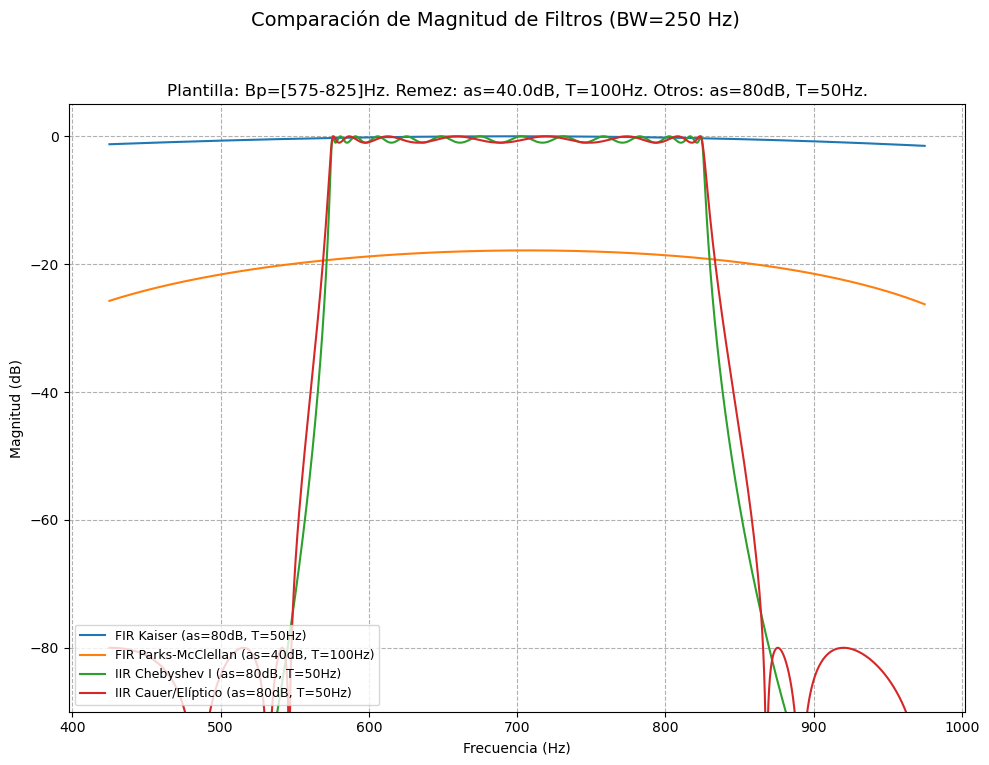

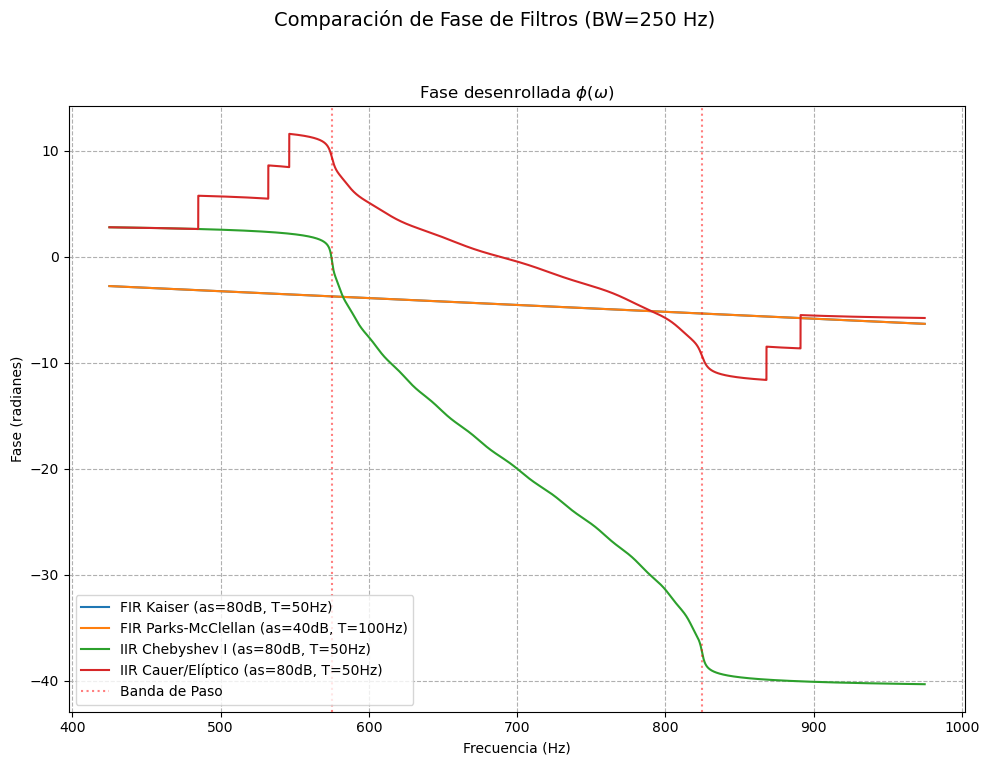

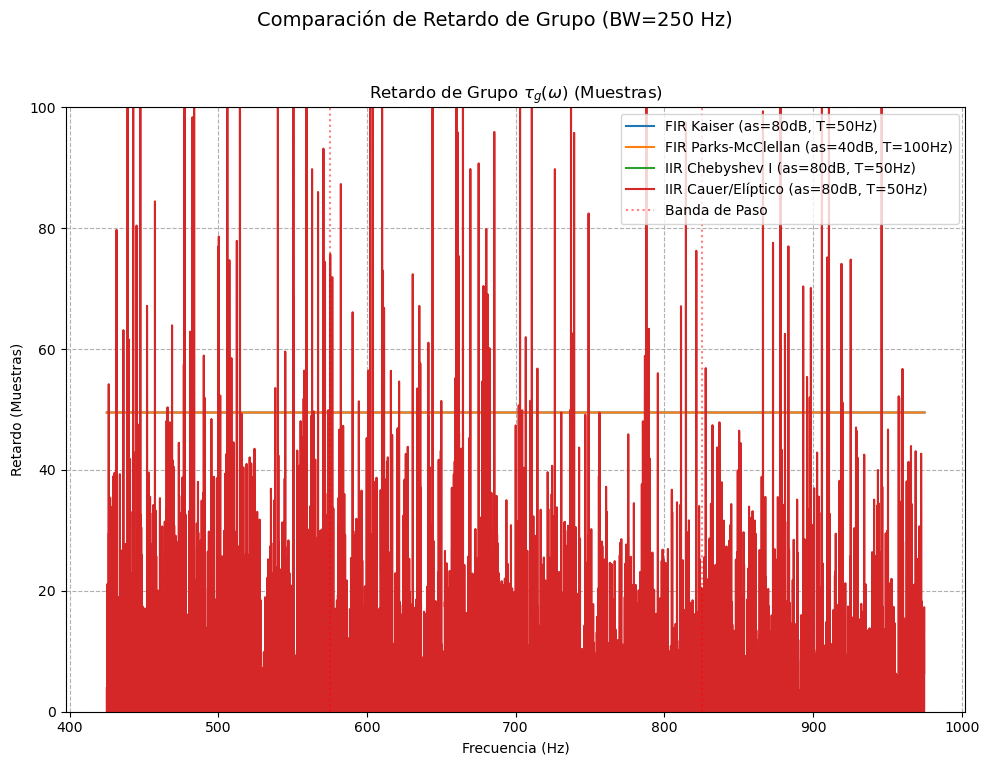

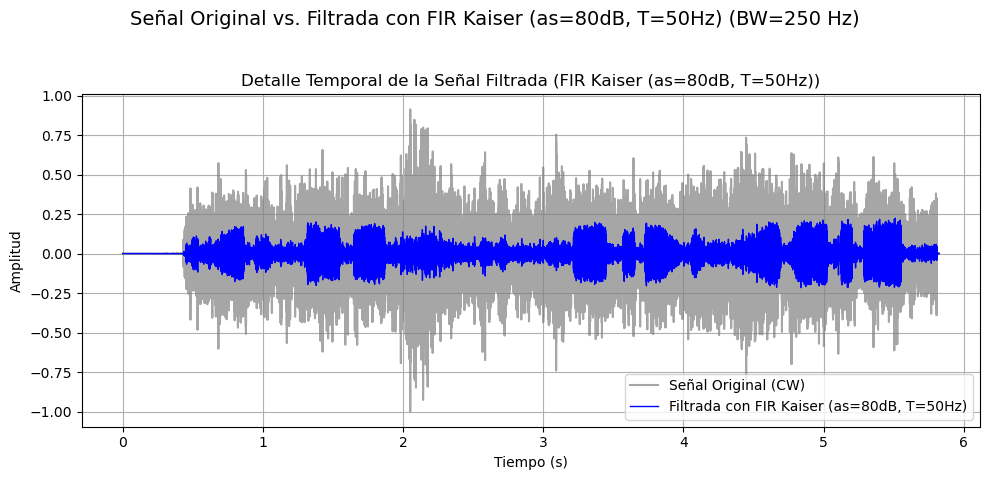

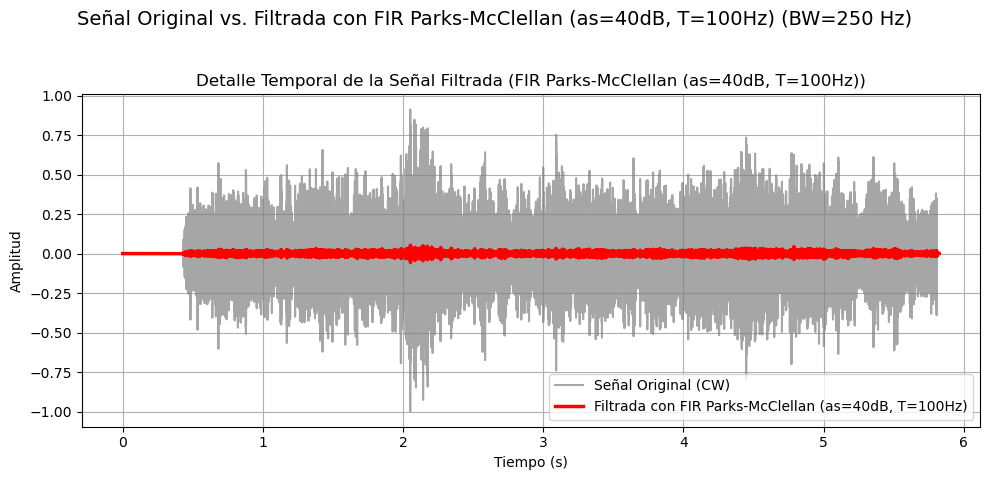

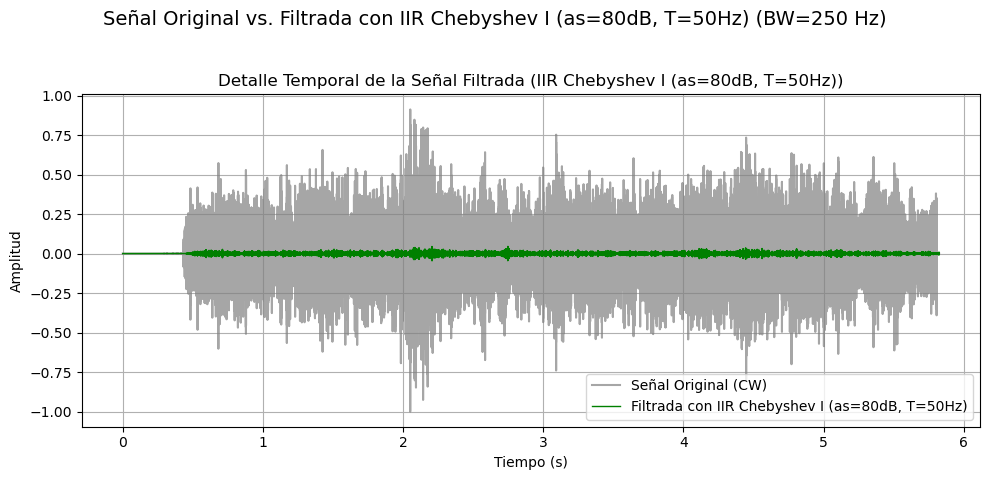

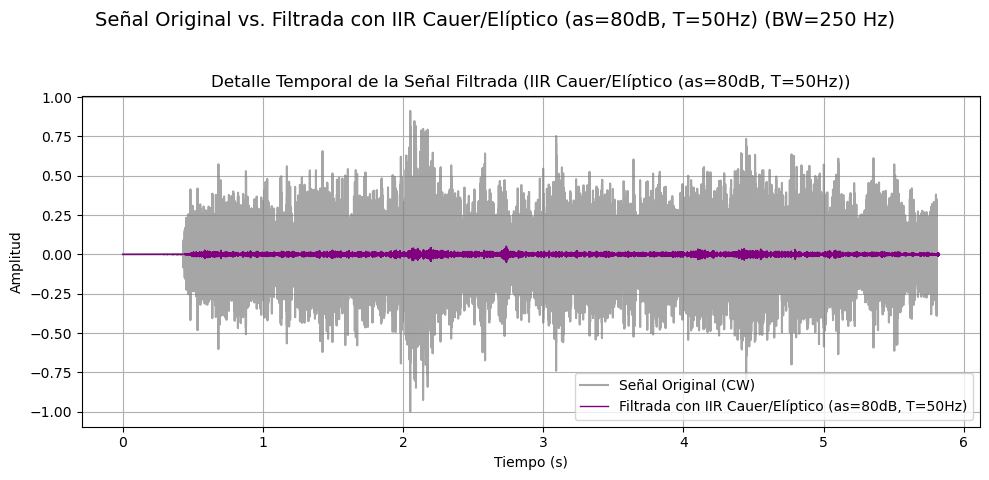

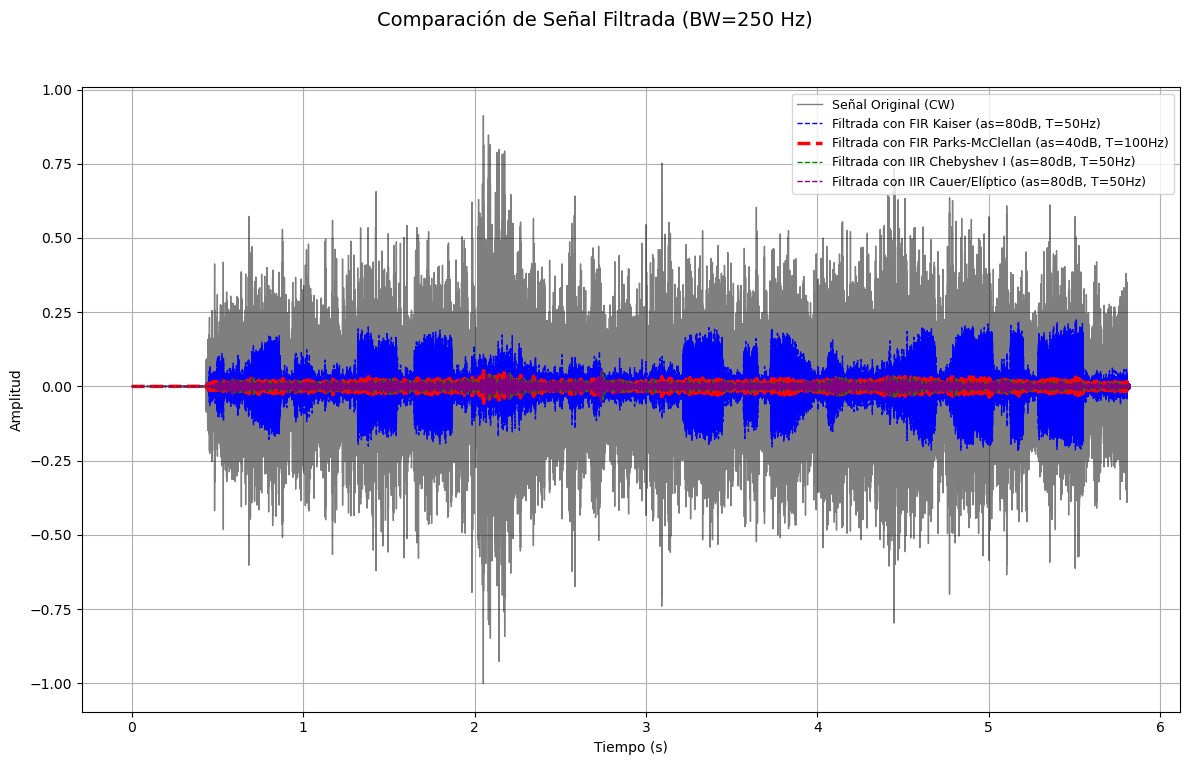

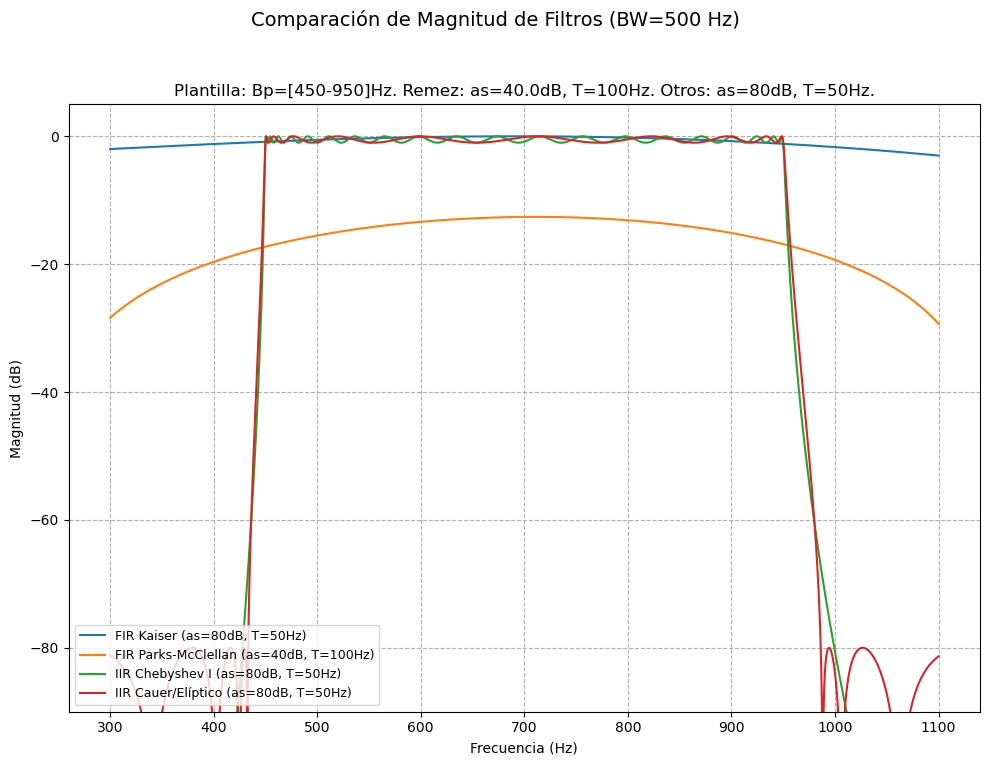

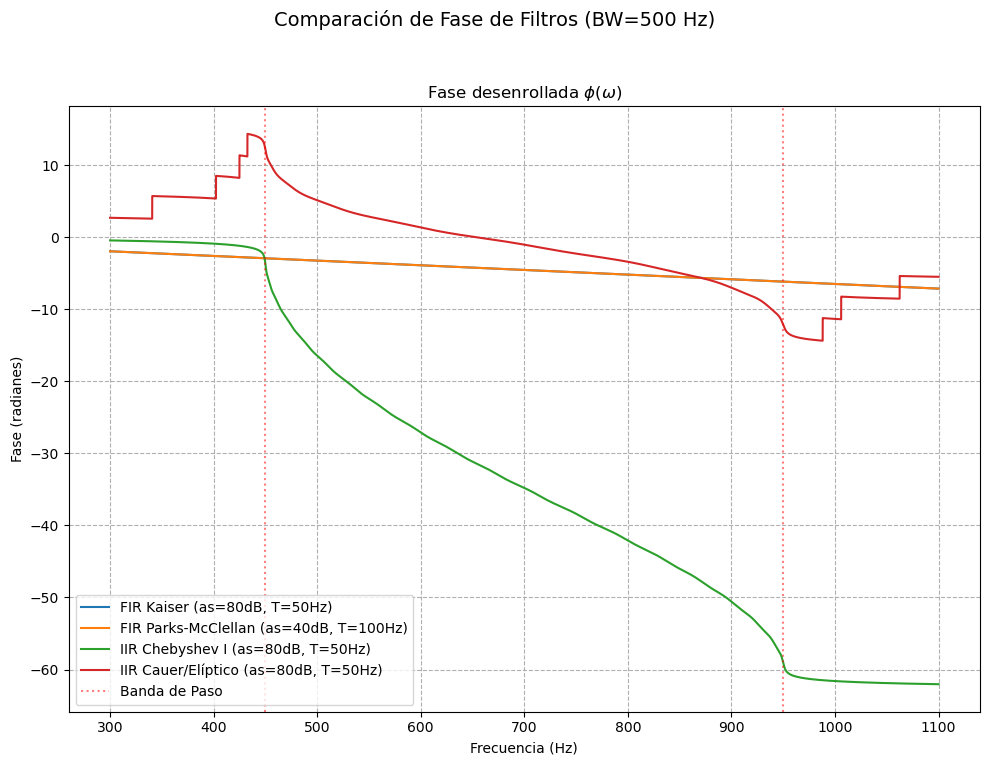

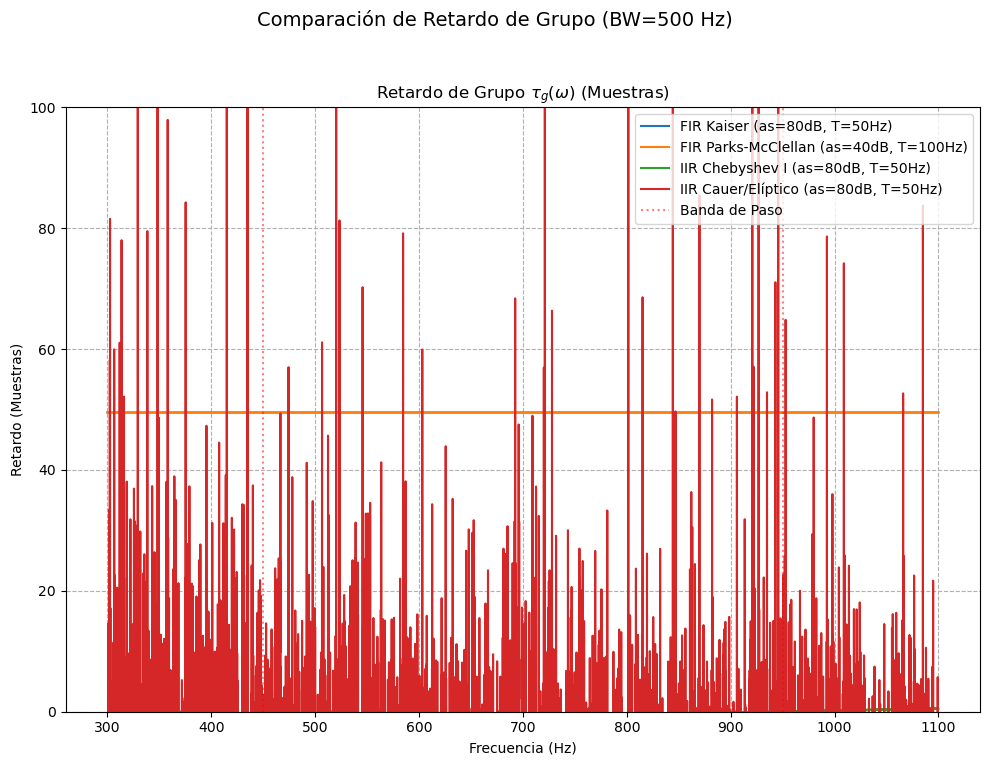

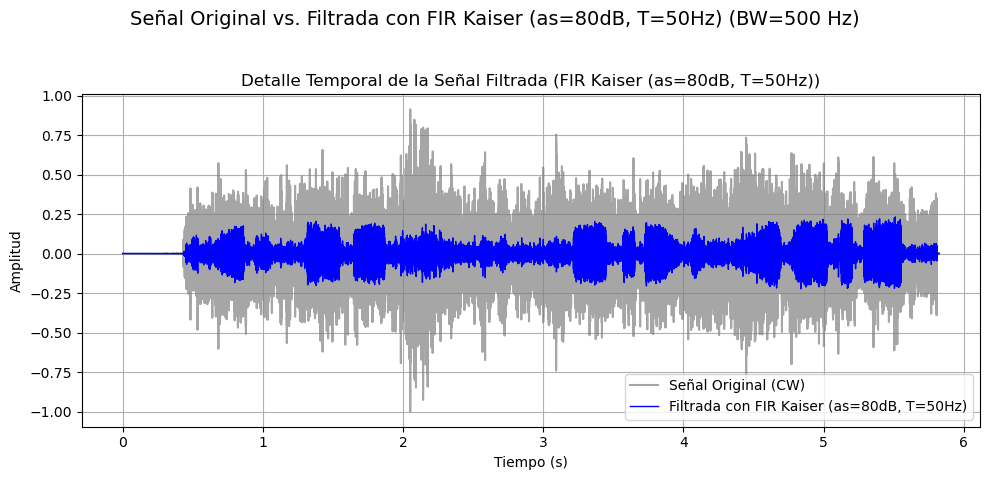

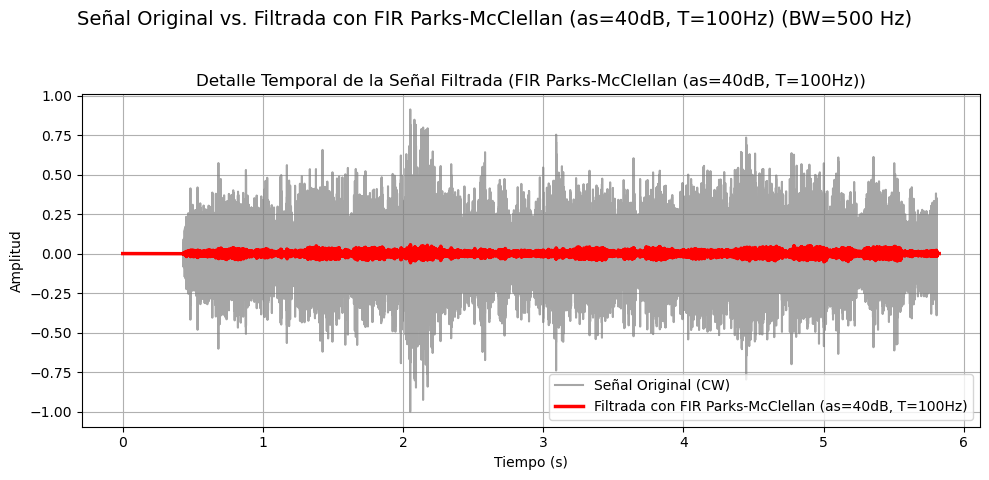

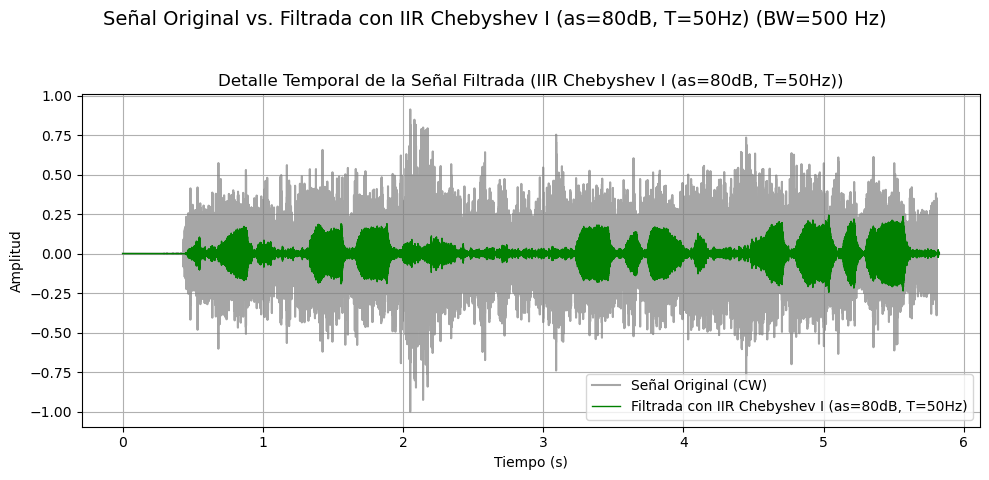

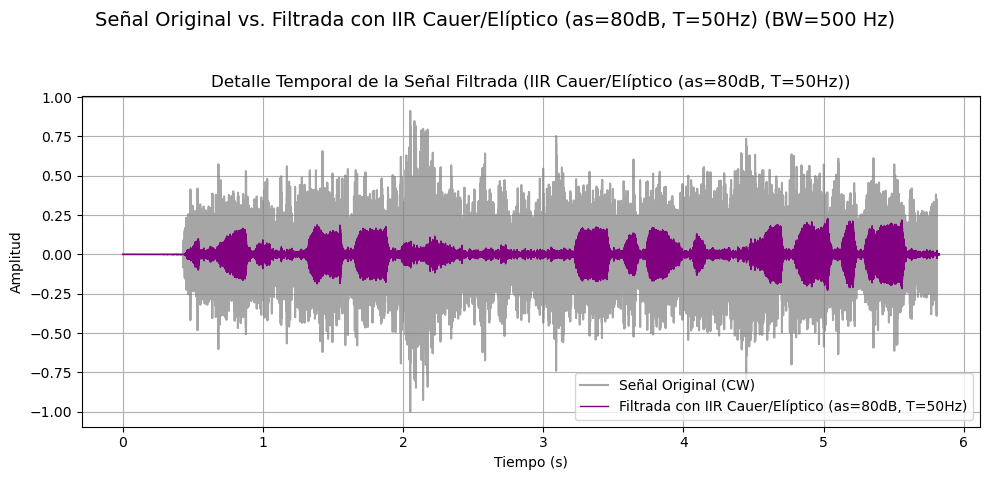

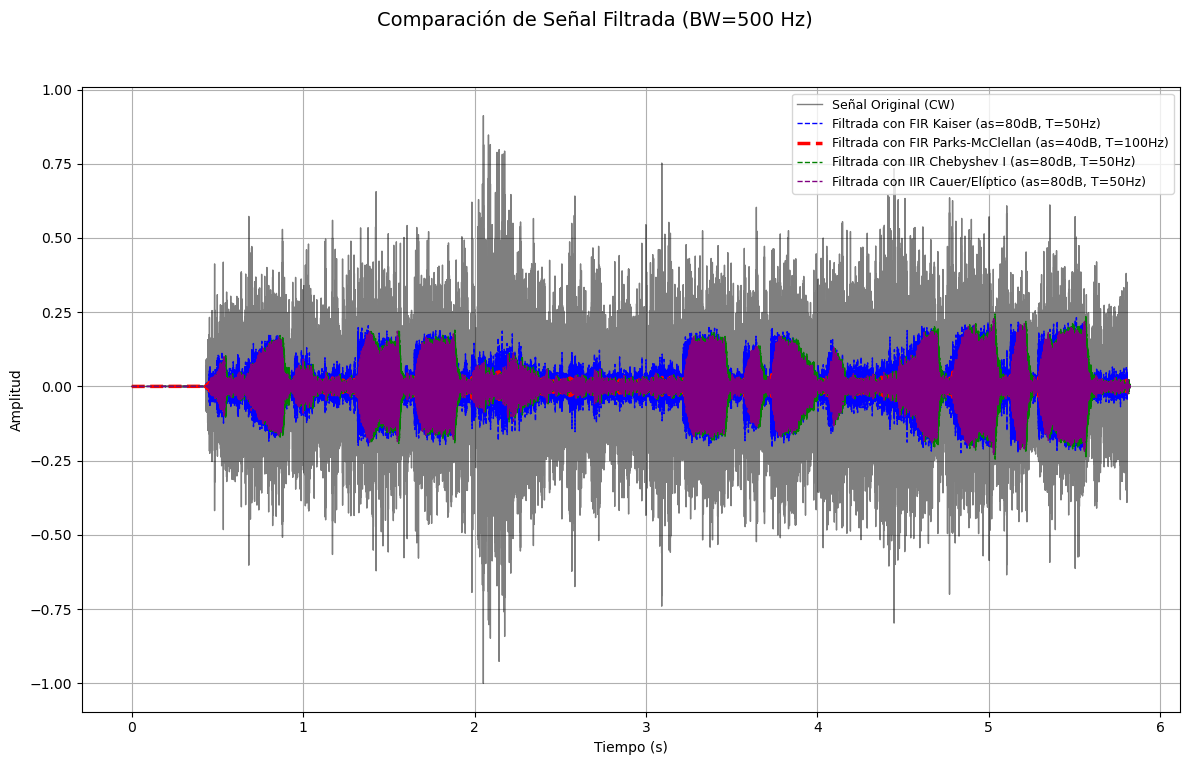

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Señal CW

Señal de telegrafía real, recibida en 7.025 MHz con un receptor TS-120S
de la firma Kenwood. El audio fue tomado con un teléfono con sistema
operativo Android

El mensaje recibido es: CQ CQ, que significa llamando a cualquier estación
que esté presente en esa frecuencia. 

El tono recibido tiene una frecuencia de 700Hz, determinada con la Ts4 de
estimación espectral.

Análisis de los 4 filtros para dos anchos de banda (250 Hz y 500 Hz).
Correcciones aplicadas:
1. Ajuste de beta para Kaiser para cumplir 80dB.
2. Ajuste del vector Remez para garantizar la atenuación.
3. Ajuste de la métrica de rizo en BP.

Los filtros normalmente utilizados para recibir telegrafía por radio, tienen
un ancho de banda de 250Hs o 500Hz.

Created on Wed Nov 12 22:35:43 2025

@author: Fernando Daniel Fiamberti
"""

import numpy as np
from scipy import signal as sig
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import os
import sys

# =========================================================================
# 1. Parámetros Globales y Carga
# =========================================================================

DATA_FILENAME = 'CW.wav'
N_FIR = 100  # Orden bajo para FIR
alpha_p = 1   # Atenuación máxima en banda de paso (dB)
alpha_s = 80  # Atenuación mínima en banda de detención (dB)
alpha_s_remez = 40.0 # Restricción relajada para Parks-McClellan a N=100

os.makedirs('resultados_CW_final', exist_ok=True)

try:
    print(f"Cargando {DATA_FILENAME}...")
    fs, signal_full = wavfile.read(DATA_FILENAME)
    if signal_full.ndim > 1:
        signal_full = signal_full[:, 0]
        
    audio_signal = signal_full.astype(np.float64) / np.max(np.abs(signal_full))
    
    FS = fs
    N_signal = len(audio_signal)
    print(f"Cargadas {N_signal} muestras. Frecuencia de muestreo: {FS} Hz")

except FileNotFoundError:
    print(f"¡Error! No se encontró el archivo '{DATA_FILENAME}'.")
    sys.exit()

# =========================================================================
# 2. Definición de Diseños por Ancho de Banda
# =========================================================================

# Definiciones de frecuencia para cada BW
DESIGN_PARAMS = {
    '250': {
        'BW_Hz': 250,
        'wp': (575, 825),       # Banda de Paso (Centro 700 Hz)
        'ws_iir': (525, 875),   # Estándar: T=50 Hz
        'ws_remez': (475, 925) # Optimizado: T=100 Hz
    },
    '500': {
        'BW_Hz': 500,
        'wp': (450, 950),       # Banda de Paso (Centro 700 Hz)
        'ws_iir': (400, 1000),  # Estándar: T=50 Hz
        'ws_remez': (350, 1050) # Optimizado: T=100 Hz
    }
}

# =========================================================================
# 3. Bucle Principal de Análisis
# =========================================================================

for BW_KEY, params in DESIGN_PARAMS.items():
    
    BW = params['BW_Hz']
    wp = params['wp']
    ws_iir = params['ws_iir']
    ws0_iir, ws1_iir = ws_iir
    ws0_remez, ws1_remez = params['ws_remez']
    wp0, wp1 = wp
    
    print(f"\n#################################################")
    print(f"## INICIANDO ANÁLISIS PARA BW = {BW} Hz ##")
    print(f"#################################################")

    # --- 3.1. Diseño de los 4 Filtros para el BW actual ---

    # 1. FIR Kaiser (Usa N=100, alpha_s=80dB, banda de transición Estándar)
    # CÁLCULO CORREGIDO de beta para alpha_s = 80dB:
    if alpha_s > 50:
        beta_kaiser = 0.1102 * (alpha_s - 8.7)
    elif alpha_s >= 21:
        beta_kaiser = 0.5842 * (alpha_s - 21)**0.4 + 0.07886 * (alpha_s - 21)
    else:
        beta_kaiser = 0.0
        
    f_corte_low = (wp0 + ws0_iir) / 2
    f_corte_high = (wp1 + ws1_iir) / 2
    b_boxcar = sig.firwin(numtaps=N_FIR, cutoff=[f_corte_low, f_corte_high], fs=FS, 
                              window=('kaiser', beta_kaiser), pass_zero=False)

    # 2. FIR Parks-McClellan (Remez) - as=40dB y banda de transición Optimizado
    # VECTOR REMEZ CORREGIDO: Se usa el peso para asegurar la atenuación
    f_remez = [0, ws0_remez, wp0, wp1, ws1_remez, FS/2]
    a_remez = [0, 1, 0] 
    # El ripple en la banda de paso (Rp) es alpha_p. El peso Ws/Wp = Rp/Rs.
    # Dado que Parks-McClellan no usa dB en sus pesos, estimamos el peso de detención (Ws)
    # usando la relación de atenuaciones deseadas (Rs/Rp).
    # Error en BP = 10^(alpha_p/20) - 1. Error en BS = 10^(-alpha_s_remez/20).
    # Peso = Error_BP / Error_BS
    remez_weight = (10**(alpha_p/20) - 1) / (10**(-alpha_s_remez/20))
    b_remez = sig.remez(numtaps=N_FIR, bands=f_remez, desired=a_remez, fs=FS, type='bandpass', 
                        weight=[remez_weight, 1, remez_weight]) # Se aplica el peso a ambas bandas de detención

    # Suprimir advertencias de diseño IIR
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", sig.BadCoefficients)
        
        # 3. IIR Chebyshev I (Usa alpha_s=80dB y banda de transición Estándar)
        N_cheb1, _ = sig.cheb1ord(wp, ws_iir, alpha_p, alpha_s, analog=False, fs=FS)
        mi_sos_cheb1 = sig.iirdesign(wp, ws_iir, gpass=alpha_p, gstop=alpha_s, 
                                     analog=False, ftype='cheby1', output='sos', fs=FS)
        
        # 4. IIR Cauer/Elíptico (Usa alpha_s=80dB y banda de transición Estándar)
        N_cauer, _ = sig.ellipord(wp, ws_iir, alpha_p, alpha_s, analog=False, fs=FS)
        mi_sos_cauer = sig.iirdesign(wp, ws_iir, gpass=alpha_p, gstop=alpha_s, 
                                     analog=False, ftype='ellip', output='sos', fs=FS)

    # --- 3.2. Estructura de Filtros y Aplicación ---
    
    FILTROS = {
        'FIR Kaiser (as=80dB, T=50Hz)': {'b': b_boxcar, 'a': 1, 'type': 'FIR', 'design_info': f'N={N_FIR}, as=80dB, T=50Hz'},
        'FIR Parks-McClellan (as=40dB, T=100Hz)': {'b': b_remez, 'a': 1, 'type': 'FIR', 'design_info': f'N={N_FIR}, as=40dB, T=100Hz'},
        'IIR Chebyshev I (as=80dB, T=50Hz)': {'sos': mi_sos_cheb1, 'type': 'IIR', 'design_info': f'N={N_cheb1}, L={len(mi_sos_cheb1)}'},
        'IIR Cauer/Elíptico (as=80dB, T=50Hz)': {'sos': mi_sos_cauer, 'type': 'IIR', 'design_info': f'N={N_cauer}, L={len(mi_sos_cauer)}'}
    }

    cw_filtrado = {}

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", sig.BadCoefficients) 
        
        for name, filter_params in FILTROS.items():
            print(f"Aplicando filtro: {name} (BW={BW} Hz)...")
            
            if filter_params['type'] == 'FIR':
                cw_filtrado[name] = sig.lfilter(filter_params['b'], filter_params['a'], audio_signal)
                
            elif filter_params['type'] == 'IIR':
                cw_filtrado[name] = sig.sosfilt(filter_params['sos'], audio_signal)

    print("\n--- Filtrado Completado. ---")
    
    # --- 3.3. Cálculo de Respuestas y Métricas ---
    
    freq_range_plot = np.linspace(wp0 - 150, wp1 + 150, 10000) # Rango de ploteo dinámico
    all_responses = {}
    performance_data = []

    for name, filter_params in FILTROS.items():
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning) 
            
            if filter_params['type'] == 'FIR':
                w, h = sig.freqz(filter_params['b'], filter_params['a'], worN=freq_range_plot, fs=FS)
                w_gd, gd = sig.group_delay((filter_params['b'], filter_params['a']), w=freq_range_plot, fs=FS)
            elif filter_params['type'] == 'IIR':
                w, h = sig.sosfreqz(filter_params['sos'], worN=freq_range_plot, fs=FS)
                b_tf, a_tf = sig.sos2tf(filter_params['sos'])
                w_gd, gd = sig.group_delay((b_tf, a_tf), w=freq_range_plot, fs=FS)
        
        mag_db = 20 * np.log10(np.abs(h) + 1e-8)
        phase = np.unwrap(np.angle(h))
        
        all_responses[name] = {'w': w, 'mag_db': mag_db, 'phase': phase, 'gd': gd, 
                               'design_info': filter_params['design_info']}
        
        # Extracción de Métricas (usando las bandas de detención propias de cada diseño)
        bp_mask = (w >= wp0) & (w <= wp1)
        
        # CÁLCULO CORREGIDO: Rizo máximo en BP (desviación absoluta de 0 dB)
        max_ripple = np.max(np.abs(mag_db[bp_mask])) if np.any(bp_mask) else np.nan
        
        if 'Parks-McClellan' in name:
            bs_low_mask = (w >= 0) & (w <= ws0_remez)
            bs_high_mask = (w >= ws1_remez) & (w <= FS/2)
        else:
            bs_low_mask = (w >= 0) & (w <= ws0_iir)
            bs_high_mask = (w >= ws1_iir) & (w <= FS/2)
            
        min_atten_low = -np.min(mag_db[bs_low_mask]) if np.any(bs_low_mask) else np.nan
        min_atten_high = -np.min(mag_db[bs_high_mask]) if np.any(bs_high_mask) else np.nan
        min_attenuation = np.min([min_atten_low, min_atten_high])
        
        orden_str = filter_params['design_info'].split(',')[0].strip()
        avg_gd = np.mean(gd[bp_mask]) if np.any(bp_mask) else np.nan
        
        performance_data.append({
            'Filtro': name,
            'Orden (N)': orden_str,
            'Rizo Máximo en BP (dB)': f"{max_ripple:.4f}",
            'Atenuación Mínima en BS (dB)': f"{min_attenuation:.1f}" if min_attenuation != np.nan else "N/A",
            'Retardo de Grupo Promedio (muestras)': f"{avg_gd:.1f}"
        })
        
        safe_name = name.replace(" ", "_").replace("(", "").replace(")", "").replace("=", "").replace("/", "_")
        
        # --- 3.4. Gráficos Individuales (Magnitud, Fase, Retardo de Grupo) ---
        
        # Magnitud Individual (Gráfico 1-4)
        plt.figure(figsize=(8, 6))
        plt.plot(w, mag_db)
        plt.title(f'Magnitud: {name} (BW={BW} Hz)', fontsize=12)
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Magnitud (dB)')
        # Se ajusta el límite inferior a 90 dB, ya que Kaiser y IIR deben cumplir 80 dB
        plt.ylim(-alpha_s - 10, 5) 
        
        plt.axhline(alpha_p, color='r', linestyle='--', alpha=0.5, label='Límite Bp (1 dB)')
        plt.axhline(-alpha_s, color='g', linestyle='--', alpha=0.5, label='Límite Bs (-80 dB)') 
        
        if 'Parks-McClellan' in name:
             plt.axhline(-alpha_s_remez, color='orange', linestyle='--', alpha=0.8, label=f'Límite Remez ({alpha_s_remez} dB)')
             plt.axvline(ws0_remez, color='m', linestyle=':', alpha=0.8, label=f'Bs Remez ({ws0_remez}/{ws1_remez}Hz)')
             plt.axvline(ws1_remez, color='m', linestyle=':', alpha=0.8)
             plt.legend(loc='upper right', fontsize=8)
        else:
             plt.axvline(ws0_iir, color='c', linestyle=':', alpha=0.5, label=f'Bs Estandar ({ws0_iir}/{ws1_iir}Hz)')
             plt.axvline(ws1_iir, color='c', linestyle=':', alpha=0.5)
             plt.legend(loc='upper right', fontsize=8)
        
        plt.axvline(wp0, color='b', linestyle=':', alpha=0.5)
        plt.axvline(wp1, color='b', linestyle=':', alpha=0.5, label='Banda de Paso')
        plt.grid(True, which="both", ls="--")
        plt.tight_layout()
        plt.savefig(f'resultados_CW_final/BW{BW}_Magnitud_{safe_name}_INDIVIDUAL.png', dpi=300)
        plt.close() 

        # Fase Individual (Gráfico 5-8)
        plt.figure(figsize=(8, 6))
        plt.plot(w, phase)
        plt.title(f'Fase: {name} (BW={BW} Hz)', fontsize=12)
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Fase (radianes)')
        plt.axvline(wp0, color='r', linestyle=':', alpha=0.5)
        plt.axvline(wp1, color='r', linestyle=':', alpha=0.5, label='Banda de Paso')
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'resultados_CW_final/BW{BW}_Fase_{safe_name}_INDIVIDUAL.png', dpi=300)
        plt.close() 
        
        # Retardo de Grupo Individual (Gráfico 9-12)
        plt.figure(figsize=(8, 6))
        plt.plot(w, gd)
        plt.title(f'Retardo de Grupo: {name} (BW={BW} Hz)', fontsize=12)
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Retardo (Muestras)')
        plt.axvline(wp0, color='r', linestyle=':', alpha=0.5)
        plt.axvline(wp1, color='r', linestyle=':', alpha=0.5, label='Banda de Paso')
        plt.ylim(0, 100)
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'resultados_CW_final/BW{BW}_RetardoGrupo_{safe_name}_INDIVIDUAL.png', dpi=300)
        plt.close() 

    # --- 3.5. Gráficos Comparativos (Magnitud, Fase, Retardo de Grupo) ---
    
    # Magnitud Comparativa (Gráfico 13)
    plt.figure(figsize=(10, 8))
    plt.suptitle(f'Comparación de Magnitud de Filtros (BW={BW} Hz)', fontsize=14)
    for name, res in all_responses.items():
        plt.plot(res['w'], res['mag_db'], label=f'{name}')
    plt.title(f'Plantilla: Bp=[{wp0}-{wp1}]Hz. Remez: as={alpha_s_remez}dB, T=100Hz. Otros: as={alpha_s}dB, T=50Hz.') 
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud (dB)')
    plt.ylim(-alpha_s - 10, 5) 
    plt.legend(loc='lower left', fontsize=9)
    plt.grid(True, which="both", ls="--")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'resultados_CW_final/BW{BW}_Magnitud_COMPARATIVA.png', dpi=300)
   


    # Fase Comparativa (Gráfico 14)
    plt.figure(figsize=(10, 8))
    plt.suptitle(f'Comparación de Fase de Filtros (BW={BW} Hz)', fontsize=14)
    for name, res in all_responses.items():
        plt.plot(res['w'], res['phase'], label=f'{name}')
    plt.title('Fase desenrollada $\\phi(\\omega)$') 
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Fase (radianes)')
    plt.axvline(wp0, color='r', linestyle=':', alpha=0.5)
    plt.axvline(wp1, color='r', linestyle=':', alpha=0.5, label='Banda de Paso')
    plt.legend(loc='lower left')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'resultados_CW_final/BW{BW}_Fase_COMPARATIVA.png', dpi=300)


    # Retardo de Grupo Comparativo (Gráfico 15)
    plt.figure(figsize=(10, 8))
    plt.suptitle(f'Comparación de Retardo de Grupo (BW={BW} Hz)', fontsize=14)
    for name, res in all_responses.items():
        plt.plot(res['w'], res['gd'], label=f'{name}')
    plt.title('Retardo de Grupo $\\tau_g(\\omega)$ (Muestras)') 
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Retardo (Muestras)')
    plt.axvline(wp0, color='r', linestyle=':', alpha=0.5)
    plt.axvline(wp1, color='r', linestyle=':', alpha=0.5, label='Banda de Paso')
    plt.ylim(0, 100) 
    plt.legend(loc='upper right')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'resultados_CW_final/BW{BW}_RetardoGrupo_COMPARATIVO.png', dpi=300)
    
    
    # --- 3.6. Gráficos de Señal Filtrada (Tiempo) ---
    t = np.arange(N_signal) / FS
    y_original = audio_signal
    
    # Cuatro Gráficos Individuales (Gráfico 16-19)
    for i, (name, signal) in enumerate(cw_filtrado.items()):
        
        plt.figure(figsize=(10, 5))
        plt.suptitle(f'Señal Original vs. Filtrada con {name} (BW={BW} Hz)', fontsize=14)
        plt.plot(t, y_original, label='Señal Original (CW)', color='gray', alpha=0.7)
        
        linewidth = 2.5 if 'Parks-McClellan' in name else 1
        
        color = 'red' if 'Parks-McClellan' in name else ('blue' if 'Kaiser' in name else ('green' if 'Chebyshev' in name else 'purple'))
            
        plt.plot(t, signal, label=f'Filtrada con {name}', color=color, linewidth=linewidth)
        plt.title(f'Detalle Temporal de la Señal Filtrada ({name})', fontsize=12)
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        safe_name = name.replace(" ", "_").replace("(", "").replace(")", "").replace("=", "").replace("/", "_")
        plt.savefig(f'resultados_CW_final/BW{BW}_Senial_{safe_name}_INDIVIDUAL_TIEMPO.png', dpi=300)


    # Gráfico Comparativo (Gráfico 20)
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Comparación de Señal Filtrada (BW={BW} Hz)', fontsize=14)

    plt.plot(t, y_original, label='Señal Original (CW)', color='black', alpha=0.5, linewidth=1)

    for name, signal in cw_filtrado.items():
        linewidth = 2.5 if 'Parks-McClellan' in name else 1
        color = 'red' if 'Parks-McClellan' in name else ('blue' if 'Kaiser' in name else ('green' if 'Chebyshev' in name else 'purple'))
        plt.plot(t, signal, label=f'Filtrada con {name}', color=color, linewidth=linewidth, linestyle='--')

    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.legend(loc='upper right', fontsize=9)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'resultados_CW_final/BW{BW}_Senial_Filtrada_COMPARATIVA_TIEMPO.png', dpi=300)


    # --- 3.7. Imprimir Tabla de Rendimiento ---
    tabla_performance = pd.DataFrame(performance_data)
    print(f"\n--- TABLA DE RENDIMIENTO NUMÉRICO (BW={BW} Hz) ---\n")
    print(tabla_performance.to_string(index=False)) 
    tabla_performance.to_csv(f'resultados_CW_final/BW{BW}_Performance_Tabla.csv', index=False)


# =========================================================================
# 4. Mostrar todos los gráficos creados
# =========================================================================
plt.show()

Se observa el mensaje en forma de interrupción del tono de audio de 700Hz. El mensaje es CQ CQ, que en términos de puntos y rayas es  C:raya punto raya punto y  Q:raya raya punto raya. Puede observarse esto en la duración correcta de la señal en el gráfico: la raya dura 3 veces el tiempo del punto. 